In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

In [109]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.8 MB/s eta 0:00:00


In [110]:
from skopt import gp_minimize
from skopt.space import Real, Integer

# Функции принадлежности

In [2]:
def gauss_mf(x, mn, std, edge=None):

  # для чисел:
  if type(x) != np.ndarray: 
    if edge == 'left':
      return np.exp(-((x-mn)/std) ** 2/2) if x > mn else 1
    elif edge == 'right':
      return np.exp(-((x-mn)/std) ** 2/2) if x < mn else 1

    return np.exp(-((x-mn)/std) ** 2/2) 

  # для массивов:
  a = np.ones_like(x, dtype=np.float16)
  if edge=='left':
    ind = np.where(x > mn)
    a[ind] = np.exp(-((x-mn)/std) ** 2/2)[ind]
    return a
  elif edge=='right':
    ind = np.where(x < mn)
    a[ind] = np.exp(-((x-mn)/std) ** 2/2)[ind]
    return a

  return np.exp(-((x-mn)/std) ** 2/2)


def mf_draw(mn, std, edge=None):
  x = np.linspace(mn - 4 * std, mn + 4 * std, 50)
  y = gauss_mf(x, mn, std, edge)
  plt.plot(x, y)

In [ ]:
#def prm_to_log_space(prm):
#  """переводит массив 5х2 (mean,std для 5ти колокольчиков) 
#  в список 9ти параметров (in log space) на оптимизацию """
#  log_prm = []
#  for term in range(-2, 2 + 1):
#    sgn = np.sign(term)
#    if sgn:
#      log_prm.append(np.log10(sgn * prm[term + 2, 0])) # очередной mean
#    log_prm.append(np.log10(prm[term + 2, 1])) # очередной std

#  return log_prm

def prm_to_log_space2(prm):
    """переводит массив 5х2 (mean,std для 5ти колокольчиков) 
    в список 9ти параметров (in log space) на оптимизацию """
    log_prm = []

    m_2 = - prm[0, 0]
    m_1 = - prm[1, 0]
    m1 = prm[3, 0]
    m2 = prm[4, 0]
    s_2, s_1, s0, s1, s2 = prm[:, 1]

    s_2 = (m_2 - m_1) / s_2
    s_1 = max(m_2 - m_1, m_1) / s_1
    s0 = max(m_1, m1)/ s0
    s1 = max(m2 - m1, m1) / s1
    s2 = (m2 - m1) / s2

    m_1 = m_1 / m_2
    m1 = m1 / m2

    # m_2 - логарифм середины крайнего левого колокольчика
    # m_1 - в диапазоне [log(0.2), log(0.8)]
    # m1 - в диапазоне [log(0.2), log(0.8)]
    # m2 - логарифм середины крайнего правого колокольчика 
    # s_2, s_1, s0, s1, s2 - в диапазоне [log(2), log(4)]
    return np.log10(np.array([m_2, m_1, m1, m2, s_2, s_1, s0, s1, s2]))


#m_2, m_1, m1, m2, s_2, s_1, s0, s1, s2 = prm_to_log_space2(prm)

def log_prm_to_lin_space2(prm):
  """inverse of prm_to_log_space2()"""
  lm_2, lm_1, lm1, lm2, ls_2, ls_1, ls0, ls1, ls2 = prm

  lin_prm = np.zeros((5, 2))

  lin_prm[0, 0] = - 10**lm_2
  lin_prm[1, 0] = lin_prm[0, 0] * 10**lm_1
  lin_prm[2, 0] = 0
  lin_prm[4, 0] = 10**lm2
  lin_prm[3, 0] = lin_prm[4, 0] * 10**lm1

  lin_prm[0, 1] = (lin_prm[1, 0] - lin_prm[0, 0]) / 10**ls_2
  lin_prm[1, 1] = max(lin_prm[1, 0] - lin_prm[0, 0], -lin_prm[1, 0]) / 10**ls_1
  lin_prm[2, 1] = max(-lin_prm[1, 0], lin_prm[3, 0])/ 10**ls0
  lin_prm[3, 1] = max(lin_prm[4, 0] - lin_prm[3, 0], lin_prm[3, 0]) / 10**ls1
  lin_prm[4, 1] = (lin_prm[4, 0] - lin_prm[3, 0]) / 10**ls2

  return lin_prm

#def log_prm_to_lin_space(prm):
#  """inverse of prm_to_log_space()"""
#  lin_prm = np.zeros((5, 2))
#  lin_prm[2, :] = [0, 10**prm[4]]
#  for i, lg in enumerate(prm[:4] + [0, 0] + prm[5:]):
#    sgn = np.sign(i // 2 - 2)
#    if sgn:
#      lin_prm[i//2, i%2] = 10**lg * sgn**(i%2 + 1)

#  return lin_prm


# проверка правильности prm_to_log_space2(), log_prm_to_lin_space2()
prm = np.array([[-4*10**-4, 0.5*10**-4], 
[-2*10**-4, 0.5*10**-4], 
[0, 0.25*10**-4],
[2*10**-4, 0.5*10**-4], 
[4*10**-4, 0.5*10**-4]])

lprm = prm_to_log_space2(prm)
print(lprm)
print(log_prm_to_lin_space2(lprm))
print('a',(np.array(prm_to_log_space2(log_prm_to_lin_space2(lprm))) - np.array(lprm)).sum())
print('b', (log_prm_to_lin_space2(prm_to_log_space2(prm)) - prm).sum().round(15))

[-3.39794001 -0.30103    -0.30103    -3.39794001  0.60205999  0.60205999
  0.90308999  0.60205999  0.60205999]
[[-4.0e-04  5.0e-05]
 [-2.0e-04  5.0e-05]
 [ 0.0e+00  2.5e-05]
 [ 2.0e-04  5.0e-05]
 [ 4.0e-04  5.0e-05]]
a 0.0
b 0.0


In [ ]:
elevator_change_linprm = np.array(
    [[-4*10**-4, 0.5*10**-4], 
     [-2*10**-4, 0.5*10**-4], 
     [0, 0.5*10**-4],
     [2*10**-4, 0.5*10**-4], 
     [4*10**-4, 0.5*10**-4]])

altitude_error_linprm = np.array(
    [[-4*10, 0.5*10], 
     [-2*10, 0.5*10], 
     [0, 0.5*10],
     [2*10, 0.5*10], 
     [4*10, 0.5*10]])

current_roc_linprm = np.array(
    [[-4, 0.5], 
     [-2, 0.5], 
     [0, 0.5],
     [2, 0.5], 
     [4, 0.5]])

## Диаграммы начальных функций принадлежности

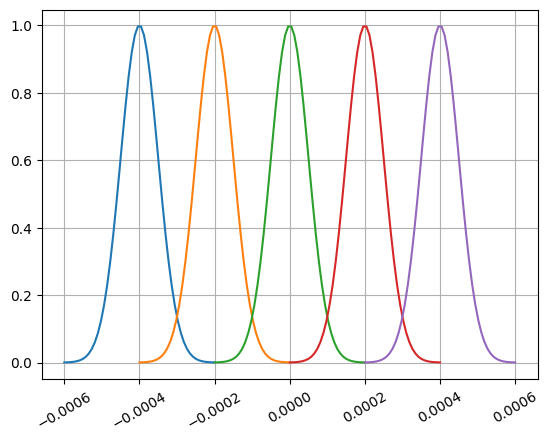

In [ ]:
# elevator change
plt.xticks(rotation=30)
plt.grid()
for tpl in elevator_change_linprm:
  mf_draw(tpl[0], tpl[1])

plt.show()

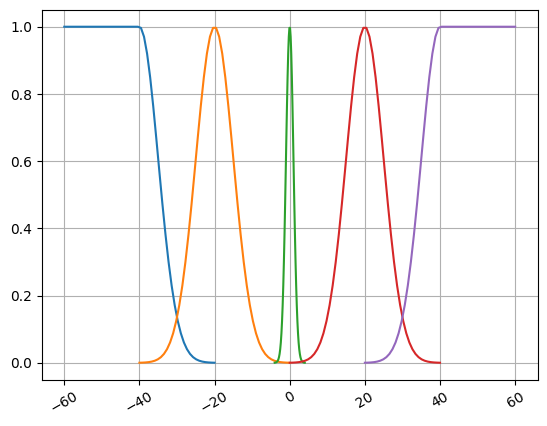

In [ ]:
# altitude error (dh)
plt.xticks(rotation=30)
plt.grid()
for i, tpl in enumerate(altitude_error_linprm):
  mf_draw(tpl[0], tpl[1], 'left' if i==0 else 'right' if i==4 else None)

plt.show()

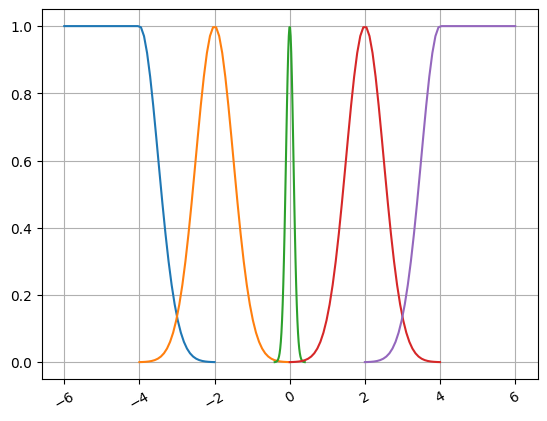

In [ ]:
# current ROC (rate of climb)
plt.xticks(rotation=30)
plt.grid()
for i, tpl in enumerate(current_roc_linprm):
  mf_draw(tpl[0], tpl[1], 'left' if i==0 else 'right' if i==4 else None)

plt.show()

In [ ]:
vmax = 5
h_th = 50
def dh_to_target_roc(dh):
  sgn = - 1 if dh > 0 else 1
  target_roc = 5 * sgn
  if -dh * sgn < h_th:
    target_roc = vmax / h_th**2 * dh**2 * sgn
  return target_roc

In [ ]:
dh_to_target_roc(200)

-5

# Правила вывода

In [9]:
rules = [
     {'droc':-2, 'accel':[-2,-1,0],'elevator':-2},
     {'droc':-2, 'accel':[1],      'elevator':-1},
     {'droc':-2, 'accel':[2],      'elevator':0}, # 0?
     {'droc':-1, 'accel':[-2, -1], 'elevator':-2},
     {'droc':-1, 'accel':[0],      'elevator':-1},
     {'droc':-1, 'accel':[1],      'elevator':0},
     {'droc':-1, 'accel':[2],      'elevator':1},
     {'droc':0, 'accel':[-2],      'elevator':-2},
     {'droc':0, 'accel':[-1],      'elevator':-1},
     {'droc':0, 'accel':[0],       'elevator':0},
     {'droc':0, 'accel':[1],       'elevator':1},
     {'droc':0, 'accel':[2],       'elevator':2},
     {'droc':1, 'accel':[-2],      'elevator':-1},
     {'droc':1, 'accel':[-1],      'elevator':0},
     {'droc':1, 'accel':[0],       'elevator':1},
     {'droc':1, 'accel':[1, 2],    'elevator':2},
     {'droc':2, 'accel':[-2],      'elevator':0}, #0
     {'droc':2, 'accel':[-1],      'elevator':1},
     {'droc':2, 'accel':[0, 1, 2], 'elevator':2},
]

In [ ]:
#class Elevator:
  def __init__(self, dh, roc):
    # определение фигуры дефузификации, по которой будет рассчитываться центр масс

    self.altitude_error_linprm = altitude_error_linprm
    self.defuzz_shapes = [] # [(mn, std для колокольчика + планка уверенности)]
    self.a = 1 # нижняя граница интегрирования для последующей итерации
    self.b = -1 # верхняя граница интегрирования

    for rule in rules:

      [mn, std] = self.altitude_error_linprm[rule['h'] + 2]
      #print(altitude_error_linprm[rule['h'] + 2])
      dh_mf = gauss_mf(dh, mn, std, edge='left' if rule['h']==-2 else 'right' if rule['h']==2 else None)

      roc_mf = 0
      for rule_roc in rule['roc']:
        [mn, std] = current_roc_linprm[rule_roc + 2]
        #print(roc, mn, std)
        x = gauss_mf(roc, mn, std, edge='left' if rule_roc==-2 else 'right' if rule_roc==2 else None)
        #print('x', x)
        if x > roc_mf:
          roc_mf = x
          #print('roc_mf', roc_mf)

      mf_value = min(dh_mf, roc_mf)
      
      if mf_value > 5e-4: #std < 3.9 sigma
        [mn, std] = elevator_change_linprm[rule['elevator'] + 2]
        self.defuzz_shapes.append((mn, std, mf_value))

        if mn - 3*std < self.a:
          self.a = mn - 3*std

        if mn + 3*std > self.b:
          self.b = mn + 3*std


  def calc_point_mf(self, x):
    # значение фигуры дефузи в точке
    y = 0
    for mn, std, mf_value in self.defuzz_shapes:
      yt = min(gauss_mf(x, mn, std), mf_value)
      if yt > y:
        y = yt
    return y


  def calc_point_xmf(self, x):
    # значение фигуры дефузи в точке * x
    y = 0
    for mn, std, mf_value in self.defuzz_shapes:
      yt = min(gauss_mf(x, mn, std), mf_value)
      if yt > y:
        y = yt
    return y*x


  def get_cm(self):
    # return: х-координата центра масс фигуры дефузи
    xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=1e-3)
    x = integrate.quad(self.calc_point_mf, self.a, self.b, epsrel=1e-3)

    return xx[0] / x[0]


# Класс Elevator

In [4]:
class Elevator:
  def __init__(self, droc_linprm, accel_linprm, elevator_change_linprm, vmax, h_th):
    
    self.droc_linprm = droc_linprm
    self.accel_linprm = accel_linprm
    self.elevator_change_linprm = elevator_change_linprm
    self.vmax = vmax
    self.h_th = h_th

  def get_target_roc(self, dh):
    sgn = - 1 if dh > 0 else 1
    target_roc = 5 * sgn
    if -dh * sgn < self.h_th:
      target_roc = self.vmax / self.h_th**2 * dh**2 * sgn
    return target_roc


  def update(self, dh, roc, accel):
    # applies rules to current state
    self.defuzz_shapes = [] # [(mn, std для колокольчика + планка уверенности)]
    self.a = 1 # нижняя граница интегрирования для последующей итерации
    self.b = -1 # верхняя граница интегрирования

    droc = roc - self.get_target_roc(dh)
    if accel==0:
      print('roc',  roc, 'target_roc', roc-droc, 'droc', droc)

    for rule in rules:
      # определение фигуры дефузификации, по которой будет рассчитываться центр масс
      [mn, std] = self.droc_linprm[rule['droc'] + 2]
      #print(altitude_error_linprm[rule['h'] + 2])
      droc_mf = gauss_mf(droc, mn, std, edge='left' if rule['droc']==-2 else 'right' if rule['droc']==2 else None)

      accel_mf = 0
      for rule_accel in rule['accel']:
        [mn, std] = self.accel_linprm[rule_accel + 2]
        #print(roc, mn, std)
        x = gauss_mf(accel, mn, std, edge='left' if rule_accel==-2 else 'right' if rule_accel==2 else None)
        #print('x', x)
        if x > accel_mf:
          accel_mf = x
          #print('roc_mf', roc_mf)

      mf_value = min(droc_mf, accel_mf)
      
      if mf_value > 5e-4: #std < 3.9 sigma
        [mn, std] = self.elevator_change_linprm[rule['elevator'] + 2]
        #if accel==0:
        #  print(droc, droc_mf, accel_mf, mf_value, 'elevator',[mn, std])
        self.defuzz_shapes.append((mn, std, mf_value))

        if mn - 3*std < self.a:
          self.a = mn - 3*std

        if mn + 3*std > self.b:
          self.b = mn + 3*std
    
    return self

  def calc_point_mf(self, x):
    # значение фигуры дефузи в точке
    y = 0
    for mn, std, mf_value in self.defuzz_shapes:
      yt = min(gauss_mf(x, mn, std), mf_value)
      if yt > y:
        y = yt
    return y


  def calc_point_xmf(self, x):
    # значение фигуры дефузи в точке * x
    y = 0
    for mn, std, mf_value in self.defuzz_shapes:
      yt = min(gauss_mf(x, mn, std), mf_value)
      if yt > y:
        y = yt
    return y*x


  def get_cm(self):
    # return: х-координата центра масс фигуры дефузи
    xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
    x = integrate.quad(self.calc_point_mf, self.a, self.b, epsrel=5e-2)

    return xx[0] / x[0] if x[0] !=0 else 0

In [ ]:
np.linspace(-20, 20, 101)

In [ ]:
%%time
#kf = 2
#r = 0.5
#dhs = [0]

#kf = 5
#r = 0.5
#dhs = [100]

#kf = 3
#r = 0.5
#dhs = [50]

kf = 3
p = 0.9
q = 0.8
r = 0.7
sigm = 0.5
dhs = [-100, -70, -50, -30, -20, -10, -5, -2, -1, -0]

elevator_change_linprm = np.array(
    [[-4*10**-4, sigm*10**-4], 
     [-p*4*10**-4, sigm*10**-4], 
     [0, sigm*10**-4],
     [p*4*10**-4, sigm*10**-4], 
     [4*10**-4, sigm*10**-4]])*kf

droc_linprm = np.array(
    [[-4, sigm], 
     [-q*4, sigm], 
     [0, sigm],
     [q*4, sigm], 
     [4, sigm]])*kf

accel_linprm = np.array(
    [[-4, sigm], 
     [-r*4, sigm], 
     [0, sigm],
     [r*4, sigm], 
     [4, sigm]])*kf

x = np.linspace(-30, 30, 101)

vmax = 5
h_th = 50

elev = Elevator(droc_linprm, accel_linprm, elevator_change_linprm, vmax, h_th)
for dh in dhs[:1]:
  y = []
  z = []
  w = []
  for accel in x:
    roc = elev.get_target_roc(dh)
    y.append(elev.update(dh, roc, accel).get_cm())
    z.append(elev.update(dh, roc+5, accel).get_cm())
    w.append(elev.update(dh, roc+10, accel).get_cm())
    #print(dh, roc, round(elev.get_cm(), 6)) #,elev.defuzz_shapes, round(elev.a, 6), round(elev.b, 6))

  plt.title('dh:'+ str(dh))
  plt.grid(True)
  plt.plot(x, y, label='droc=0')

  plt.plot(x, z, label='droc=5')
  plt.plot(x, w, label='droc=10')
  plt.legend()
  plt.show()

In [ ]:
kf = 10
p = 0.3
q = 0.5
r = 0.3
sigm = 0.5

kf = 10
p = 0.3
q = 0.5
r = 0.25
sigm = 0.5

kf = 7
p = 0.3
q = 0.5
r = 0.25
sigm = 0.5

In [20]:
# sic! save, do not change
kf = 7
p = 0.25
q = 0.5
r = 0.25
sigm = 0.5

#elevator_change_linprm = np.array(
    [[-4*10**-4, sigm*10**-4], 
     [-p*4*10**-4, sigm*10**-4], 
     [0, sigm*10**-4],
     [p*4*10**-4, sigm*10**-4], 
     [4*10**-4, sigm*10**-4]])*kf*300

droc_linprm = np.array(
    [[-4, sigm], 
     [-q*4, sigm], 
     [0, sigm],
     [q*4, sigm], 
     [4, sigm]])*kf

accel_linprm = np.array(
    [[-4, sigm], 
     [-r*4, sigm], 
     [0, sigm],
     [r*4, sigm], 
     [4, sigm]])*kf


In [89]:
kf = 7
e = 0.5
d = 0.3
a = 0.5
sigme = 0.5
sigmd = 0.9
sigma = 0.35

elevator_change_linprm = np.array(
    [[-4*10**-4, sigme*10**-4], 
     [-e*4*10**-4, sigme*10**-4], 
     [0, sigme*10**-4],
     [e*4*10**-4, sigme*10**-4], 
     [4*10**-4, sigme*10**-4]])*kf*300

droc_linprm = np.array(
    [[-4, sigmd], 
     [-d*4, sigmd], 
     [0, sigmd],
     [d*4, sigmd], 
     [4, sigmd]])*kf

accel_linprm = np.array(
    [[-4, sigma], 
     [-a*4, sigma], 
     [0, sigma],
     [r*4, sigma], 
     [4, sigma]])*kf

In [142]:
len_int = 7
eps = 0.25
def last_in_neib(a, len_int, val, eps):
  x = min(a[-len_int:])
  y = max(a[-len_int:])
  ret = 0
  if (len(a) > len_int) and (np.abs(val-x) < eps) and (np.abs(val-y) < eps):
    ret = len(a)
  return ret

In [103]:
a = np.arange(40, 0, -1)/20
last_in_neib(a, len_int, 0, eps)

0

In [7]:
def objective(params):
  global j
  print('*******************************************')
  kf, e, d, a, sigme, sigmd, sigma, k = params
  elevator_change_linprm = np.array(
    [[-4*10**-4, sigme*10**-4], 
     [-e*4*10**-4, sigme*10**-4], 
     [0, sigme*10**-4],
     [e*4*10**-4, sigme*10**-4], 
     [4*10**-4, sigme*10**-4]])*kf*300

  droc_linprm = np.array(
      [[-4, sigmd], 
      [-d*4, sigmd], 
      [0, sigmd],
      [d*4, sigmd], 
      [4, sigmd]])*kf

  accel_linprm = np.array(
      [[-4, sigma], 
      [-a*4, sigma], 
      [0, sigma],
      [a*4, sigma], 
      [4, sigma]])*kf*k

  dh = 0
  roc = 20
  accel = 10
  x = [roc]
  y = [accel]

  len_int = 7
  eps = 0.25

  elev = Elevator(droc_linprm, accel_linprm, elevator_change_linprm, vmax, h_th)
  target_roc = elev.get_target_roc(dh)
  print(j, params, 'target roc', target_roc)
  j += 1

  for i in range(500):
    da = -elev.update(dh, roc, accel).get_cm()
    #print(da, elev.get_target_roc(dh))
    roc += accel*0.1
    accel += da 
    x.append(roc)
    y.append(accel)
    resd = last_in_neib(x, len_int, target_roc, eps)
    resa = last_in_neib(y, len_int, 0, eps)
    if resd > 0 and resa > 0:
      break

  if resd > 0 and resa > 0:
    print(i, 'converged\n  ', x[-10:], '\n  ', y[-10:])
    return i
  else:
    print(i, 'not converged')
    return 1000

#Оптимизация

In [179]:
%%time
j = 1

#[8.0, 0.4482615728279592, 0.4, 0.3, 0.6, 1.0, 0.40159328860944826]
#[7.3318991979570995, 0.4151489772114996, 0.3935303871302819, 0.33088971172147186, 0.5095661097308338, 0.9136748763262117, 0.4025186815914397]

search_space = [
  Real(7.00, 89.0, prior='uniform', name='kf'),
  Real(0.65, 0.75, prior='uniform', name='e'),
  Real(0.3, 0.5, prior='uniform', name='d'), 
  Real(0.01, 0.2, prior='uniform', name='a'), 
  Real(0.7, 0.9, prior='uniform', name='sigme'),
  Real(0.7, 0.92, prior='uniform', name='sigmd'), 
  Real(0.1, 0.3, prior='uniform', name='sigma'),
  Real(0.9, 1.3, prior='uniform', name='k')
]

result = gp_minimize(objective, search_space, n_calls=100, n_random_starts=10)
print(f'Best parameters: {result.x}')
print(f'Best score: {result.fun}')

*******************************************
1 [58.89415764469764, 0.7010092534946866, 0.46840473657451104, 0.15313278696390129, 0.7612543391186863, 0.7178950547218633, 0.15829275779951163, 0.9067259663576128] target roc 0.0
499 not converged
*******************************************
2 [29.040276045848838, 0.7080238869885512, 0.4402511249714761, 0.15501237040314292, 0.708220903235243, 0.8742627254300485, 0.23882791058375058, 1.1625283171109824] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


206 converged
   [0.27956823956646343, 0.2697960899988032, 0.25890018441269513, 0.24697720069854537, 0.23423125453540752, 0.22067867968840985, 0.20642971750578668, 0.19159410838829055, 0.17627233232921893, 0.16053110398879783] 
   [-0.09772149567660207, -0.10895905586108118, -0.11922983714149755, -0.12745946163137845, -0.13552574846997667, -0.14248962182623173, -0.14835609117496135, -0.15321776059071615, -0.15741228340421093, -0.16016033590948703]
*******************************************
3 [30.867247822039587, 0.6568518232569404, 0.48272542865728546, 0.07234892474835407, 0.8393910855089011, 0.7588573244820684, 0.18379078964224232, 1.1345670090546167] target roc 0.0
499 not converged
*******************************************
4 [52.990206147185255, 0.7465652673966044, 0.3623772275532693, 0.08971632582161368, 0.8807337889683939, 0.8885649520725638, 0.13959155729161854, 0.9285036612104559] target roc 0.0
134 converged
   [0.07276137734449986, 0.044301872062744135, 0.01725552076598683,

<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


270 converged
   [0.29335423245809034, 0.27972947883536886, 0.2648024156901019, 0.24870728216822588, 0.23157733591736818, 0.21354893470019584, 0.19475585579456664, 0.17532613782472203, 0.15539892570846037, 0.13511507352997282] 
   [-0.13624753622721456, -0.14927063145266986, -0.16095133521875996, -0.17129946250857697, -0.18028401217172335, -0.1879307890562921, -0.19429717969844607, -0.19927212116261664, -0.20283852178487535, -0.20507098485573552]
*******************************************
12 [40.441728452029935, 0.7078757124112001, 0.4219080031568253, 0.08501958748599896, 0.8505276635973796, 0.8874326868482258, 0.2374189738370034, 0.9271610125961713] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


336 converged
   [0.2593339611634712, 0.25577618354403553, 0.2522672989075551, 0.24880663040258774, 0.2453934825570311, 0.24202721396051932, 0.23870719989598835, 0.23543280515327697, 0.23220338539736332, 0.22901829922267725] 
   [-0.03557777619435671, -0.035088846364803875, -0.034606685049673784, -0.034131478455566376, -0.03366268596511789, -0.03320014064530983, -0.032743947427113895, -0.03229419755913652, -0.031850861746860866, -0.03141380115687191]
*******************************************
13 [37.437225919366625, 0.7404153825715578, 0.40845886023462863, 0.15472760261034993, 0.728430134446336, 0.862363334873714, 0.1252771184670594, 1.1637266764726983] target roc 0.0
499 not converged
*******************************************
14 [89.0, 0.65, 0.3578222985449234, 0.2, 0.7, 0.92, 0.3, 0.9] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


265 converged
   [-0.006649544662929885, 0.021480165902511245, 0.04861077117178703, 0.07463445747414427, 0.09945124740242928, 0.12297154354357123, 0.14512009311364507, 0.16582636910028126, 0.18502732277894582, 0.202668775505857] 
   [0.2812971056544113, 0.27130605269275787, 0.26023686302357224, 0.2481678992828501, 0.23520296141141947, 0.22148549570073847, 0.2070627598663619, 0.1920095367866456, 0.1764145272691118, 0.16041403859130013]
*******************************************
15 [89.0, 0.65, 0.3, 0.01, 0.9, 0.7, 0.1, 1.3] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


172 converged
   [0.0607148688546902, 0.03233837334545093, 0.00511349416657015, -0.020917666532793106, -0.04571869789621266, -0.06925896360184079, -0.09151416902647508, -0.1124674285228578, -0.13210449828026616, -0.15041590308066113] 
   [-0.2837649550923927, -0.2722487917888078, -0.26031160699363254, -0.24801031363419554, -0.23540265705628124, -0.22255205424634286, -0.20953259496382726, -0.19637069757408354, -0.1831140480039498, -0.16979349334753535]
*******************************************
16 [58.397014701732715, 0.659221639102148, 0.3030367585263684, 0.09489971020044786, 0.7760469547244726, 0.7322999495744295, 0.20269464782044583, 1.2688359344647724] target roc 0.0
75 converged
   [0.04218618648234346, 0.004147926243866229, -0.029174733234559276, -0.05814665240976921, -0.08313003149798494, -0.10444350843597437, -0.1224427815784045, -0.1374301555653912, -0.14968902864140016, -0.159484353863807] 
   [-0.3803826023847723, -0.33322659478425504, -0.28971919175209937, -0.24983379088215

<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


499 not converged
*******************************************
18 [61.049532294305614, 0.7023344040782176, 0.3403518641442154, 0.09122530091792243, 0.7064830915292083, 0.8871363080880978, 0.18311711151433152, 0.9276665375758388] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


110 converged
   [0.29520561854091265, 0.2787700533796391, 0.26324386550820833, 0.24857345530810687, 0.2347256092424237, 0.22165433101697446, 0.20931602933905197, 0.19766982490612664, 0.18667737410447807, 0.1762854147080199] 
   [-0.16435565161273538, -0.15526187871430774, -0.1467041020010145, -0.13847846065683186, -0.13071278225449237, -0.12338301677922481, -0.11646204432925322, -0.10992450801648569, -0.10391959396458168, -0.09784607254228156]
*******************************************
19 [82.9871213043449, 0.75, 0.38897222488480937, 0.12517344145739193, 0.7, 0.92, 0.27261822684993997, 0.9839169152420693] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


106 converged
   [-0.2935171865586852, -0.27800636719563127, -0.2625372631667922, -0.24718969046703615, -0.23203475459361395, -0.21713545045479687, -0.2025486676652201, -0.18832173702913976, -0.17449590623496575, -0.16110584405389825] 
   [0.15510819363053907, 0.1546910402883903, 0.15347572699756062, 0.151549358734222, 0.1489930413881706, 0.1458678278957678, 0.14226930636080332, 0.13825830794174007, 0.13390062181067508, 0.12925076859010462]
*******************************************
20 [31.41192250622999, 0.7443205711918733, 0.3, 0.09453714705847648, 0.7, 0.854908287300826, 0.13556547300623492, 0.9] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


190 converged
   [-0.09650592574739308, -0.06993698436176525, -0.04393196123006128, -0.018620357427453472, 0.005876477443098514, 0.029449046442527986, 0.05199000106690203, 0.07341063123015257, 0.09362236965178007, 0.1125570629869615] 
   [0.2656894138562783, 0.26005023131703964, 0.25311603802607807, 0.24496834870551984, 0.2357256899942947, 0.22540954624374038, 0.21420630163250537, 0.20211738421627506, 0.18934693335181424, 0.17594134538307846]
*******************************************
21 [72.39606918596857, 0.6622067803834907, 0.3591705086941796, 0.11182298500312433, 0.8322325242297632, 0.92, 0.23151040499600137, 0.9900995751206567] target roc 0.0
86 converged
   [0.26097073321565095, 0.22900442895923928, 0.19979561211743452, 0.17316138761824998, 0.14892371195064447, 0.12691255487586597, 0.10696666208628891, 0.08892394769299038, 0.07265934172532625, 0.058032027892933276] 
   [-0.3196630425641168, -0.2920881684180475, -0.2663422449918454, -0.24237675667605513, -0.22011157074778495, -0.

<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


210 converged
   [0.26346521205186035, 0.2586930814579674, 0.25400815817521044, 0.2494086998618366, 0.24489303658186276, 0.24045955256438284, 0.23610626832854453, 0.23183173244884692, 0.22763453675049553, 0.22351329742502574] 
   [-0.047721305938929565, -0.046849232827569545, -0.04599458313373816, -0.045156632799738396, -0.044334840174799266, -0.043532842358383186, -0.04274535879697619, -0.04197195698351401, -0.041212393254697985, -0.04046645385604341]
*******************************************
25 [49.795199904823534, 0.6519030311954102, 0.41745324626337676, 0.13341586038833572, 0.8105170264255303, 0.8561713258077998, 0.25176610334225635, 1.2466576768348931] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


106 converged
   [-0.3138545564680337, -0.28637542916175873, -0.25999836572669, -0.2347537060962374, -0.2106628544453321, -0.18773772258026333, -0.16598505646618777, -0.14540546121530262, -0.12599275419635309, -0.10774087217810109] 
   [0.2747912730627494, 0.2637706343506875, 0.2524465963045258, 0.24090851650905326, 0.2292513186506875, 0.2175266611407556, 0.20579595250885144, 0.19412707018949532, 0.18251882018251997, 0.17109799512692356]
*******************************************
26 [53.00762166538367, 0.65, 0.30414755992648623, 0.09602091567367596, 0.844113279168613, 0.7372732566422756, 0.20532011181444396, 1.3] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


89 converged
   [-0.2654210726755732, -0.2593720900685422, -0.25246383757163043, -0.2448428905267208, -0.23664214960813645, -0.22798179074190145, -0.21896820279813883, -0.20970186712022845, -0.20027020803224638, -0.19075186159139432] 
   [0.060489826070309824, 0.06908252496911786, 0.0762094704490961, 0.08200740918584347, 0.08660358866235003, 0.09013587943762603, 0.09266335677910376, 0.09431659087982087, 0.09518346440852056, 0.09536956770523707]
*******************************************
27 [69.89236861416214, 0.6535547096102963, 0.3538799647652696, 0.1191039775812763, 0.7, 0.92, 0.24399117203269066, 0.9] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


109 converged
   [0.28975482956726517, 0.27361870206547195, 0.2583701461509947, 0.24395975535697284, 0.23034243853138467, 0.21747837423883704, 0.20532603632982366, 0.19384392218948918, 0.18299740951767002, 0.17275251751373288] 
   [-0.16136127501793243, -0.15248555914477288, -0.14410390794021852, -0.1361731682558816, -0.12864064292547644, -0.12152337909013392, -0.11482114140334469, -0.10846512671819145, -0.10244892003937145, -0.0967612878694204]
*******************************************
28 [64.5639242227914, 0.75, 0.4327251559622821, 0.15251742527756978, 0.7357103444015991, 0.92, 0.29740293678152224, 0.9106212440915803] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


109 converged
   [-0.23250607649989435, -0.20372847755819856, -0.17622861613780783, -0.1500545415938944, -0.12523974441899732, -0.10180948773733449, -0.0797797749770678, -0.05915610399011672, -0.03993760697989487, -0.022113825123669606] 
   [0.28777598941695787, 0.2749986142039074, 0.2617407454391342, 0.24814797174897077, 0.23430256681662834, 0.22029712760266687, 0.2062367098695108, 0.1921849701022185, 0.1782378185622526, 0.16446706954994805]
*******************************************
29 [7.0, 0.65, 0.3399741915852223, 0.01, 0.9, 0.7066069932039964, 0.10451654109305206, 1.1548947780709042] target roc 0.0
499 not converged
*******************************************
30 [32.05055182601895, 0.75, 0.3219248708667232, 0.13793528071564473, 0.9, 0.92, 0.3, 1.2947002694660688] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


174 converged
   [-0.305193650573738, -0.2864175529291004, -0.2670528750210096, -0.24723374201454457, -0.2270884101351616, -0.20674197951724724, -0.18631414045515793, -0.16591905735189916, -0.14566424407410047, -0.12565338788899572] 
   [0.18776097644637543, 0.1936467790809084, 0.1981913300646503, 0.20145331879382974, 0.2034643061791436, 0.20427839062089315, 0.20395083103258776, 0.20254813277798686, 0.20010856185104756, 0.19671442251111276]
*******************************************
31 [65.1518588376985, 0.702926888851387, 0.3, 0.10464716153611525, 0.858745074648299, 0.92, 0.281976116233498, 1.2893039082194855] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


116 converged
   [-0.22450700733164736, -0.1966203103634387, -0.17016276747150183, -0.1451321645941607, -0.12152174814341385, -0.09931774330011083, -0.07849909271785112, -0.059043127444237106, -0.040925688411581285, -0.02411738318223152] 
   [0.27886696968208674, 0.2645754289193687, 0.2503060287734112, 0.23610416450746854, 0.22204004843303027, 0.20818650582259707, 0.1945596527361401, 0.18117439032655822, 0.16808305229349763, 0.15534171145436407]
*******************************************
32 [56.856519240853125, 0.75, 0.3, 0.0923051222797423, 0.845765432429602, 0.92, 0.12191166865569311, 0.9376888352658299] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


423 converged
   [-0.29451662446664895, -0.2799923278202337, -0.2642052120572026, -0.24725993836338028, -0.22925734917623325, -0.2103188493612216, -0.19056036817225358, -0.17010033476357989, -0.1490588480699625, -0.12755728911464312] 
   [0.14524296646415247, 0.15787115763031087, 0.16945273693822302, 0.18002589187147022, 0.1893849981501163, 0.19758481188968036, 0.20460033408673708, 0.21041486693617373, 0.21501558955319372, 0.21838896756416798]
*******************************************
33 [50.229220240892616, 0.715757747226449, 0.468471927600009, 0.08908491505620007, 0.8987123381291761, 0.8365211345469523, 0.15461279397947078, 1.1106957286635812] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


144 converged
   [0.2996683555879672, 0.2809455363131432, 0.2631609508760871, 0.24628425589245792, 0.23028458298324048, 0.21513074039672855, 0.20079139224817913, 0.18723521722222183, 0.17443104845519625, 0.1623479961945891] 
   [-0.18722819274823987, -0.17784585437056052, -0.1687669498362918, -0.15999672909217438, -0.15153842586511931, -0.1433934814854943, -0.13556175025957307, -0.12804168767025587, -0.12083052260607169, -0.11392441474407859]
*******************************************
34 [58.76967413611725, 0.6697608228570004, 0.3, 0.09466127389798505, 0.7644565170283183, 0.7545896751165335, 0.20429397199923424, 1.251388894428537] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


75 converged
   [-0.030282385743002363, -0.0687470068707357, -0.10251795111679712, -0.13160767115607158, -0.15640598325171706, -0.17728637599145838, -0.19458686695800648, -0.20863641495926477, -0.21974404276413795, -0.22819740054873516] 
   [-0.38464621127733334, -0.3377094424606142, -0.2908972003927446, -0.2479831209564547, -0.20880392739741316, -0.17300490966548096, -0.14049548001258286, -0.11107627804873184, -0.08453357784597218, -0.06068318760584803]
*******************************************
35 [52.07575951051059, 0.7349290632991131, 0.3, 0.09234045740055821, 0.7369734301099939, 0.7919074366166611, 0.15854341285575613, 0.9427168131941145] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


102 converged
   [-0.03866340160657366, -0.007729570998254744, 0.02066382586726273, 0.046551821055857596, 0.0698672889629911, 0.09067981585794714, 0.10911820933383297, 0.12526598832432229, 0.13921242310833123, 0.15105440854406213] 
   [0.30933830608318913, 0.28393396865517473, 0.25887995188594864, 0.2331546790713351, 0.20812526894956035, 0.18438393475885823, 0.16147778990489306, 0.1394643478400896, 0.11841985435730903, 0.0983963257376755]
*******************************************
36 [70.72214092646985, 0.673830993585272, 0.3, 0.10891954406751958, 0.8763201347826397, 0.92, 0.239461955426862, 1.1238135555523923] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


109 converged
   [-0.29269369614812263, -0.2734632240363193, -0.2548391301753275, -0.23684866777219513, -0.21951320581895542, -0.2028520895582658, -0.1868755368213301, -0.171587872405689, -0.1569922851364921, -0.14308846147895513] 
   [0.19230472111803362, 0.18624093860991775, 0.17990462403132365, 0.17335461953239717, 0.16661116260689623, 0.15976552736935712, 0.1528766441564109, 0.1459558726919691, 0.13903823657536982, 0.1321164597266329]
*******************************************
37 [52.86756872196208, 0.75, 0.44891537702693357, 0.01, 0.8059825916887382, 0.7149475235833812, 0.12234445469158388, 0.9] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


180 converged
   [0.3074793125201055, 0.28261357784901503, 0.25862188381020185, 0.23548623080434966, 0.21319218411573793, 0.19173755257130692, 0.17108613627719363, 0.15121856763614158, 0.13211611471274431, 0.1137585984334395] 
   [-0.24865734671090498, -0.23991694038813158, -0.23135653005852194, -0.22294046688611718, -0.21454631544430994, -0.20651416294113284, -0.19867568641052039, -0.19102452923397278, -0.18357516279304822, -0.1762927997288285]
*******************************************
38 [76.71756730121328, 0.7279008016707973, 0.3, 0.11671982179084693, 0.7579630860140126, 0.92, 0.23371158284653412, 0.9] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


107 converged
   [-0.2723358149902667, -0.24466454252490302, -0.2183116829410478, -0.19328400285086228, -0.16960049202518074, -0.1472536726173405, -0.12622772131530308, -0.10649985230424024, -0.08805039397841713, -0.07085123850448981] 
   [0.2767127246536369, 0.26352859583855226, 0.2502768009018551, 0.2368351082568153, 0.22346819407840252, 0.21025951302037396, 0.1972786901106284, 0.18449458325823112, 0.17199155473927324, 0.159799499034841]
*******************************************
39 [60.163427798269346, 0.6753875659678109, 0.3, 0.12490603421640899, 0.7083850667398509, 0.92, 0.22784175368626416, 1.0391645604681106] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


114 converged
   [0.03070270385087808, 0.0633111641854627, 0.09321973026503298, 0.12048947470282495, 0.14519226783882352, 0.16740942949273196, 0.18722274925078486, 0.2047310146486825, 0.22001608595787595, 0.23317625248496837] 
   [0.32608460334584627, 0.29908566079570276, 0.27269744437791965, 0.24702793135998577, 0.2221716165390843, 0.19813319758052894, 0.17508265397897665, 0.1528507130919342, 0.13160166527092432, 0.11133171007177906]
*******************************************
40 [69.6277316164643, 0.65, 0.5, 0.13779152394153027, 0.78508346065641, 0.8459567160958887, 0.277942147103859, 1.1266208312889834] target roc 0.0
222 converged
   [0.26687757222675096, 0.26091023965109267, 0.25507417465344095, 0.24936661344152963, 0.24378673513204624, 0.23833167817267528, 0.23299864595095157, 0.22778490521006342, 0.22268778451740207, 0.2177046727825253] 
   [-0.05967332575658303, -0.05836064997651733, -0.05707561211911324, -0.055798783094833826, -0.05455056959370945, -0.05333032221723709, -0.052

<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


130 converged
   [0.28631658861045156, 0.2696238483112234, 0.25259392729254704, 0.23535161938147953, 0.21800994749732072, 0.2006749577312341, 0.1834442877448827, 0.16640926979024193, 0.14965203147251394, 0.13324538775536288] 
   [-0.16692740299228198, -0.17029921018676347, -0.17242307911067498, -0.17341671884158805, -0.17334989766086628, -0.17230669986351407, -0.1703501795464076, -0.16757238317727977, -0.16406643717151057, -0.15986262773258506]
*******************************************
42 [86.64464520494639, 0.7240575496752611, 0.49666542787475726, 0.11757287852126332, 0.7, 0.9130972502745953, 0.28656686205907145, 0.9] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


398 converged
   [0.25866091619196857, 0.25560389675124756, 0.2525889990126045, 0.24961462858328098, 0.2466794133958676, 0.243782162861416, 0.24092183495476835, 0.23809040039776705, 0.2352884510756963, 0.23251639863118972] 
   [-0.030570194407210035, -0.03014897738643042, -0.029743704293235206, -0.029352151874133932, -0.028972505344516074, -0.028603279066476434, -0.028314345570013118, -0.0280194932207077, -0.02772052444506574, -0.027418899369841206]
*******************************************
43 [58.53779424169728, 0.6601557495338763, 0.3, 0.09563928265330507, 0.8021820116600133, 0.7642398183279788, 0.20330147266368093, 1.2635446058423305] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


93 converged
   [-0.28439913340026574, -0.27288045661305377, -0.26107739737283375, -0.2490935952173042, -0.2370217160220242, -0.22494402362449645, -0.2129332467904711, -0.20105329611273523, -0.18936082669821064, -0.17790378370852397] 
   [0.11518676787211977, 0.11803059240220005, 0.1198380215552955, 0.12071879195279998, 0.12077692397527763, 0.1201077683402534, 0.11879950677735869, 0.11692469414524584, 0.11457042989686668, 0.11181623309185906]
*******************************************
44 [58.29388295203821, 0.6765854367703547, 0.31455355500994703, 0.09394974621598232, 0.8618370717058572, 0.7000875744555429, 0.2025385709754161, 1.1145077887305834] target roc 0.0
101 converged
   [0.3009797647048743, 0.2788657195361072, 0.25817220244699457, 0.2388262272080966, 0.22075649148581739, 0.2038937544985525, 0.1881710655279853, 0.17353337022781554, 0.15990837352498946, 0.14723747639190973] 
   [-0.2211404516876706, -0.20693517089112684, -0.1934597523889798, -0.18069735722279223, -0.168627369872

<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


142 converged
   [-0.04055698875380144, -0.07055276279287659, -0.09836749732904472, -0.12398486328416244, -0.14739947179165702, -0.16862814834452267, -0.18768864892746256, -0.20461308137191736, -0.2194405121195215, -0.23221589636935283] 
   [-0.2999577403907514, -0.2781473453616813, -0.2561736595511772, -0.23414608507494564, -0.2122867655286563, -0.19060500582939904, -0.169244324444548, -0.14827430747604142, -0.12775384249831326, -0.10778623456658205]
*******************************************
46 [57.59243913652048, 0.6763579834535131, 0.40128303687574096, 0.09462443237050656, 0.7, 0.8641186301199337, 0.2044905031429196, 1.2743337631132263] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


134 converged
   [0.2705173993825735, 0.2606232023349744, 0.25112819435541434, 0.24201616610014048, 0.23327157465889328, 0.2248795172707648, 0.2168256953383713, 0.20909641002892262, 0.20167852294522065, 0.19455943285392843] 
   [-0.09894197047599126, -0.09495007979560045, -0.0911202825527384, -0.08744591441247208, -0.08392057388128484, -0.08053821932393501, -0.07729285309448652, -0.07417887083701966, -0.0711909009129223, -0.06832379836248967]
*******************************************
47 [58.553608018213, 0.6711393064261312, 0.3, 0.09579025913130136, 0.7, 0.8352960610266107, 0.2143825956328611, 1.3] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


79 converged
   [-0.03787939333594538, -0.0747919936455341, -0.10722664382723715, -0.13553313528740749, -0.16001992465870354, -0.18099159247030083, -0.19873476122739683, -0.21353192764425627, -0.2256374712770312, -0.23529295896544294] 
   [-0.3691260030958872, -0.3243465018170305, -0.28306491460170335, -0.24486789371296053, -0.20971667811597297, -0.17743168757096012, -0.1479716641685944, -0.12105543632774952, -0.09655487688411735, -0.07429931954330242]
*******************************************
48 [55.62586226425262, 0.65, 0.3, 0.10162760726213933, 0.7, 0.8000219245794576, 0.2764900950344269, 1.3] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


105 converged
   [-0.302873052697885, -0.2810930432405915, -0.25999892441825245, -0.2396320293566937, -0.22002588851088514, -0.2012062282006385, -0.18319264188115336, -0.16599909268720445, -0.14963390251609796, -0.13410017227893134] 
   [0.21780009457293534, 0.21094118822339014, 0.20366895061558746, 0.1960614084580856, 0.1881966031024664, 0.18013586319485134, 0.17193549193948926, 0.1636519017110648, 0.1553373023716663, 0.14703816754198792]
*******************************************
49 [43.47268822741479, 0.7325288169071591, 0.37010935026374236, 0.013985446943300894, 0.8753197873684457, 0.7547325128655483, 0.13406122259280462, 0.9264719223542198] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


168 converged
   [-0.2700202468415308, -0.26132440671666946, -0.252633026440856, -0.24396306627583111, -0.23533041456716913, -0.22675018489544504, -0.21823595999239667, -0.20980065321956606, -0.20145695127335692, -0.1932159372066412] 
   [0.0869584012486134, 0.08691380275813428, 0.08669960165024884, 0.08632651708661968, 0.08580229671724082, 0.08514224903048383, 0.08435306772830611, 0.08343701946209137, 0.082410140667157, 0.0812810512511875]
*******************************************
50 [79.63254525918917, 0.729133226385742, 0.3, 0.12326533532371654, 0.8305558287965308, 0.8880280541547201, 0.2641332964734924, 0.9681283729225976] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


107 converged
   [-0.03631050833964137, -0.005893228993799904, 0.021995246096103167, 0.04742587905462156, 0.07047470566463801, 0.09122513671638097, 0.10976244571908164, 0.12617548718361732, 0.1405584140142462, 0.15300782600781715] 
   [0.30417279345841464, 0.2788847508990307, 0.2543063295851839, 0.23048826610016446, 0.20750431051742949, 0.1853730900270067, 0.16413041464535674, 0.14382926830628878, 0.12449411993570952, 0.10614866627181863]
*******************************************
51 [56.46383154113401, 0.697714894415562, 0.3, 0.10008817249419577, 0.7, 0.8546740179385142, 0.20616458595552595, 1.3] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


107 converged
   [-0.20715648628946254, -0.178589880094166, -0.15169720548950177, -0.1264597369894062, -0.10285529893814965, -0.08083834072188521, -0.060379316562042894, -0.041440715420750694, -0.02399807617311646, -0.008005925681069694] 
   [0.28566606195296534, 0.26892674604664213, 0.2523746850009555, 0.2360443805125656, 0.22016958216264435, 0.20459024159842318, 0.18938601141292197, 0.17442639247634234, 0.15992150492046764, 0.14589046290437974]
*******************************************
52 [62.58347121710646, 0.6878562281294209, 0.3, 0.0929087129739438, 0.7, 0.8619052202036621, 0.21666098449445287, 1.3] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


82 converged
   [-0.0237271260774359, -0.05774005284555945, -0.08790759021857222, -0.11436343576854115, -0.13739247971557797, -0.1572589641837802, -0.17424212708049588, -0.1885517601810668, -0.20041199695212458, -0.2100454153478324] 
   [-0.34012926768123547, -0.30167537373012776, -0.26455845549968926, -0.23029043947036826, -0.19866484468202206, -0.16983162896715703, -0.14309633100570923, -0.11860236771057783, -0.09633418395707816, -0.07595122502191103]
*******************************************
53 [50.896822685345356, 0.728868349807327, 0.3481587418415424, 0.09162815390677474, 0.741809081900222, 0.7597148918112052, 0.16296219303349846, 1.3] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


101 converged
   [0.032968664676088354, 0.06451735156849174, 0.09296904275457755, 0.11838686885362514, 0.1408509472653236, 0.16045479109619892, 0.1771904004732076, 0.1912964362670431, 0.20289632450725265, 0.21212037141301074] 
   [0.3154868689240338, 0.28451691186085815, 0.2541782609904758, 0.22464078411698474, 0.19603843830875323, 0.16735609377008684, 0.14106035793835497, 0.11599888240209554, 0.0922404690575809, 0.06978302508788324]
*******************************************
54 [82.28074405543752, 0.7141494026020663, 0.4054087410275589, 0.12659587302973782, 0.7452230624117411, 0.8432301120943351, 0.2537277861232619, 0.9721261373423633] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


94 converged
   [0.18829060771828365, 0.15622354364017435, 0.1269603114613604, 0.10034615482764958, 0.0762280278236537, 0.05445853530814582, 0.034893684467326214, 0.017395541509050177, 0.001828946806423315, -0.011938332400604146] 
   [-0.32067064078109303, -0.2926323217881397, -0.2661415663371081, -0.2411812700399588, -0.21769492515507882, -0.19564850840819598, -0.17498142958276036, -0.15566594702626863, -0.1376727920702746, -0.12106143437248118]
*******************************************
55 [38.773005983563976, 0.695362528868355, 0.3, 0.12898552429993668, 0.7, 0.8475843300473909, 0.2465944205333727, 0.9472751598427805] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


108 converged
   [-0.19017978743252173, -0.15982749436547006, -0.13127924532493826, -0.10452439262971332, -0.07954980457622426, -0.05632983727608633, -0.034833348463602365, -0.014713876189282146, 0.003728730938089394, 0.020548130021574896] 
   [0.30352293067051667, 0.2854824904053179, 0.2675485269522494, 0.24974588053489055, 0.23219967300137936, 0.2149648881248396, 0.2011947227432022, 0.18442607127371538, 0.168193990834855, 0.1524860594547459]
*******************************************
56 [52.61815334556089, 0.7352520619924113, 0.3, 0.08850067698217126, 0.8066560779311369, 0.710520462084276, 0.15410709051594096, 1.1719479417853724] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


114 converged
   [0.3023042418963236, 0.2825419375460634, 0.2621576748258849, 0.2413565826885488, 0.2203313059979368, 0.19926128286997616, 0.1783120090941118, 0.1576350735650577, 0.13736813851047946, 0.11763510031556892] 
   [-0.19762304350260212, -0.20384262720178437, -0.20801092137336133, -0.21025276690611988, -0.21070023127960635, -0.20949273775864358, -0.20676935529054077, -0.2026693505457823, -0.19733038194910535, -0.190889971968301]
*******************************************
57 [32.21581423381109, 0.724955404321044, 0.5, 0.14833178010338488, 0.7287532528883709, 0.917294707886967, 0.2730836252047832, 0.9056247907894573] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


155 converged
   [0.2662684513591106, 0.25852928391121055, 0.2510697633353078, 0.24388039507456696, 0.23695014474977455, 0.23026988532988435, 0.22385983832883613, 0.21767936180893344, 0.21172022815725222, 0.20597473101752245] 
   [-0.07739167447900064, -0.07459520575902776, -0.07189368260740814, -0.06930250324792402, -0.0668025941989019, -0.06410047001048218, -0.06180476519902691, -0.05959133651681209, -0.057454971397297716, -0.05539528391769569]
*******************************************
58 [42.107053511953765, 0.65, 0.3350122209252483, 0.01, 0.7353995840892009, 0.7555318869683649, 0.11189510519985485, 1.2658265712202885] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


220 converged
   [-0.19335888434093798, -0.167662548969647, -0.14220358384426113, -0.1170558804019788, -0.09229369585836467, -0.06798505153306088, -0.04419545245551529, -0.02098637703868145, 0.0015840093135347302, 0.023461900054128713] 
   [0.25696335371290996, 0.2545896512538587, 0.25147703442282326, 0.2476218454361413, 0.2430864432530379, 0.23789599077545592, 0.23209075416833835, 0.2257038635221618, 0.2187789074059398, 0.211355188207942]
*******************************************
59 [49.49961425577446, 0.7437773142340336, 0.3, 0.11035024232931985, 0.8067761321339084, 0.7686269657232745, 0.2837545945672576, 1.2709362331831784] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


106 converged
   [-0.3040471930182969, -0.28456505965919626, -0.26588960273875173, -0.24803336516273228, -0.23100236519088516, -0.21479832774487576, -0.19941820522822712, -0.18485473831266072, -0.17109752766778885, -0.15813301609535743] 
   [0.19482133359100637, 0.18675456920444547, 0.17856237576019438, 0.1703099997184713, 0.16204037446009403, 0.15380122516648637, 0.1456346691556641, 0.13757210644871856, 0.12964511572431425, 0.12187435600783378]
*******************************************
60 [83.07764825366183, 0.72577396185702, 0.36387429555666445, 0.12036055674697957, 0.7018271345165626, 0.92, 0.2503041702673924, 0.9] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


96 converged
   [-0.2672142745544967, -0.26118361450463307, -0.2544568836762242, -0.24714775558310365, -0.23935883692811022, -0.23118448946529047, -0.22271057888239448, -0.2140150809132049, -0.20516829331848024, -0.19623366456885896] 
   [0.0603066004986365, 0.06726730828408864, 0.07309128093120562, 0.07788918654993426, 0.08174347462819749, 0.0847391058289598, 0.0869549796918959, 0.0884678759472466, 0.08934628749621289, 0.0897033427042926]
*******************************************
61 [47.49522926772554, 0.65, 0.3360454286916341, 0.10705119246108075, 0.812393597541386, 0.8666288066736181, 0.24798155320219936, 1.3] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


103 converged
   [-0.2797535483402216, -0.2673246362086555, -0.25489754504927414, -0.24253489801867084, -0.2302917468245678, -0.21821618438581697, -0.20635084090329783, -0.19473205805217073, -0.18338792614375388, -0.17234904310862278] 
   [0.12428912131566108, 0.12427091159381344, 0.12362647030603291, 0.12243151194103041, 0.12075562438750823, 0.1186534348251913, 0.11618782851127119, 0.11344131908416852, 0.110388830351311, 0.10711195903947825]
*******************************************
62 [7.0, 0.6600116072856023, 0.5, 0.17184776139122637, 0.8878074870727921, 0.9051801318032784, 0.3, 1.1095588238816825] target roc 0.0
129 converged
   [-0.14691788948022227, -0.11735366691223312, -0.08960087140972757, -0.06362073761506126, -0.039355222631307835, -0.016752325906803218, 0.0042430287665489, 0.023688109760095114, 0.041641292102747515, 0.058142552936824035] 
   [0.29564222567989157, 0.2775279550250555, 0.2598013379466631, 0.24265514983753428, 0.22602896724504615, 0.20995354673352115, 0.19445

<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


108 converged
   [0.2829537024021918, 0.2675216101553831, 0.2529324059536514, 0.23914162348753495, 0.22610455862711423, 0.2137799067572808, 0.20212867840762566, 0.19111421525815642, 0.18066188873464814, 0.1707440489847993] 
   [-0.15432092246808707, -0.14589204201731681, -0.13790782466116447, -0.13037064860420727, -0.12324651869833404, -0.11651228349655156, -0.11014463149469238, -0.10452326523508264, -0.09917839749848838, -0.0936956041042402]
*******************************************
67 [41.47684291144569, 0.65, 0.3898522194196536, 0.12209730628633349, 0.8359677734652469, 0.7, 0.2671659763977775, 0.9] target roc 0.0
229 converged
   [0.2629179001368671, 0.2575291651910604, 0.25225080377400866, 0.24708076249515282, 0.24201684237277668, 0.23705673127607899, 0.23219832737808135, 0.22743954743607792, 0.22277834234250984, 0.21821280116145753] 
   [-0.05388734945806695, -0.05278361417051737, -0.051700412788558414, -0.05063920122376139, -0.04960111096697692, -0.048584038979976304, -0.047587

<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


197 converged
   [0.2960478452489122, 0.2779973531963193, 0.2590960334877502, 0.2394960831031151, 0.2193440975229804, 0.1987851271411696, 0.17794412017560304, 0.1569592000191882, 0.13596471071974986, 0.11508738313889741] 
   [-0.18050492052592904, -0.189013197085691, -0.19599950384635084, -0.20151985580134685, -0.20558970381810796, -0.2084100696556657, -0.20984920156414844, -0.20994489299438346, -0.20877327580852445, -0.20642173188117666]
*******************************************
69 [55.86457330114502, 0.65, 0.3581833629567137, 0.14028935333072184, 0.7, 0.7674170659279436, 0.3, 0.9] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


103 converged
   [0.2934336291481988, 0.27670325208081387, 0.26092100684013486, 0.24603347809604373, 0.23198978866242487, 0.2187379917754625, 0.20623340786468788, 0.19443368632731683, 0.18329890368697943, 0.1727914748444964] 
   [-0.16730377067384972, -0.15782245240679024, -0.14887528744091127, -0.14043689433618867, -0.13251796886962364, -0.125045839107746, -0.1179972153737105, -0.11134782640337408, -0.10507428842483044, -0.09915519613356048]
*******************************************
70 [11.24550815492755, 0.65, 0.37877135549854857, 0.15530252119550217, 0.7, 0.92, 0.2780804862786339, 1.1971250692466038] target roc 0.0
150 converged
   [0.285234843817552, 0.2707141592124141, 0.2557550098552365, 0.24046041607186044, 0.22492855650851715, 0.2092525762087235, 0.19352069601942662, 0.1778156851255124, 0.1622147567276312, 0.14678956653996142] 
   [-0.1452068460513791, -0.14959149357177595, -0.15294593783376087, -0.15531859563343303, -0.1567598029979365, -0.15731880189296876, -0.1570501089391

<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


156 converged
   [0.2745061116764509, 0.26547117909897916, 0.2567346101255605, 0.24828649139824702, 0.24011721514244097, 0.23221748363022918, 0.22457831854885515, 0.21719106016210366, 0.2100473445782264, 0.20313911095695344] 
   [-0.09034932577471746, -0.08736568973418664, -0.08448118727313463, -0.08169276255806038, -0.07899731512211806, -0.07639165081374033, -0.07387258386751507, -0.07143715583877246, -0.06908233621272954, -0.06680507325170164]
*******************************************
72 [73.78614862654564, 0.6780222706702702, 0.3573645459020297, 0.11279124321888731, 0.7623807231144001, 0.92, 0.23062042973650201, 1.3] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


107 converged
   [-0.1694906418234011, -0.13956660149020966, -0.11154498491524714, -0.0853987231049003, -0.06109639057068461, -0.03860002023987888, -0.017865895473125466, 0.0011547582307513474, 0.018515106663021082, 0.03427205499794523] 
   [0.29924040333191443, 0.2802161657496252, 0.2614626181034684, 0.24302332534215695, 0.2249637033080573, 0.20734124766753412, 0.1902065370387681, 0.17360348432269734, 0.15756948334924148, 0.1421360761449314]
*******************************************
73 [53.4400334762289, 0.6840426850602068, 0.3432377685172063, 0.11797595547662276, 0.9, 0.92, 0.23867540061738954, 1.297838845602158] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


131 converged
   [0.29075954832872436, 0.2754363114920165, 0.25978943519316133, 0.2439267049863444, 0.22794877043035872, 0.21194967563444245, 0.19601637095625035, 0.18022895950107326, 0.16466079896845076, 0.14937832939601925] 
   [-0.15323236836707893, -0.15646876298855117, -0.15862730206816958, -0.15977934555985673, -0.1599909479591628, -0.15933304678192106, -0.15787411455177083, -0.15568160532622513, -0.1528246957243152, -0.14936829853420538]
*******************************************
74 [46.62498946577453, 0.6826816639698233, 0.33602205595941725, 0.09921158832505803, 0.7217051902318814, 0.9193186503579824, 0.3, 1.3] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


119 converged
   [-0.3056228599054363, -0.28561645157204535, -0.2662881792605782, -0.2476573846996667, -0.2297322644226171, -0.2125193111356969, -0.19602336124005626, -0.1802442525259347, -0.16517895173029132, -0.15082167763557536] 
   [0.20006408333390968, 0.19328272311467173, 0.18630794560911498, 0.1792512027704959, 0.17212953286920227, 0.1649594989564062, 0.1577910871412156, 0.150653007956434, 0.1435727409471596, 0.13656670874756294]
*******************************************
75 [83.57729524305759, 0.6889219925952255, 0.36324859359888934, 0.12529060854975044, 0.8272291251534243, 0.7515479266627209, 0.23555434861208438, 0.9] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


79 converged
   [0.029601386254259773, -0.006636953537796593, -0.03849366215021458, -0.06629416582172251, -0.09035290956158058, -0.11096841606515392, -0.12843065830816827, -0.14300958828736976, -0.1549598823333801, -0.16452330196161558] 
   [-0.3623833979205637, -0.3185670861241799, -0.27800503671507926, -0.24058743739858074, -0.20615506503573333, -0.17462242243014353, -0.14578929979201502, -0.11950294046010346, -0.09563419628235487, -0.07405631279340606]
*******************************************
76 [7.0, 0.65, 0.5, 0.2, 0.7, 0.7, 0.3, 1.2038938386787201] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


196 converged
   [0.2717354318839936, 0.26435570430761324, 0.25694196554701015, 0.24950785657061697, 0.24206614812052837, 0.2346290231420178, 0.22720804474403444, 0.21981407464630798, 0.2124574374266129, 0.2051478507367901] 
   [-0.07379727576380357, -0.0741373876060306, -0.0743410897639317, -0.07441708450088595, -0.07437124978510562, -0.07420978397983367, -0.07393970097726468, -0.07356637219695067, -0.07309586689822818, -0.07253433862387901]
*******************************************
77 [80.48377880897144, 0.7146082459453558, 0.3672700041896224, 0.12504952675085368, 0.7616671102606847, 0.7262163528707346, 0.2357783166231811, 1.0381604063131136] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


99 converged
   [-0.2797076123834831, -0.26545072487287813, -0.25097502504147634, -0.23639535023126482, -0.22181517441543971, -0.2073273007788947, -0.1930143121802418, -0.17894921436750727, -0.1651954566658639, -0.15180843381123346] 
   [0.1425688751060497, 0.14475699831401792, 0.14579674810211535, 0.145801758158251, 0.14487873636545015, 0.14312988598652904, 0.14065097812734517, 0.1375375770164336, 0.13387022854630448, 0.1297318124099901]
*******************************************
78 [89.0, 0.6843725377508172, 0.36051334990756767, 0.12593243192993434, 0.8558890824119638, 0.92, 0.23720945552636266, 0.9] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


101 converged
   [-0.24591575574414887, -0.21771403883511622, -0.19105670266364375, -0.16593328396041496, -0.14233284548648933, -0.12023714732545951, -0.09962203779339995, -0.08045783138363119, -0.06272149799158763, -0.046370452017696843] 
   [0.2820171690903264, 0.2665733617147247, 0.2512341870322879, 0.2360043847392562, 0.22095698161029823, 0.20615109532059558, 0.19164206409768766, 0.17736333392043552, 0.16351045973890788, 0.1502203011504084]
*******************************************
79 [39.21032013922913, 0.665696404907288, 0.3, 0.09656590208388938, 0.7746931302573806, 0.8392529438837067, 0.28398729828514885, 1.3] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


114 converged
   [-0.294467093356951, -0.27325905198630485, -0.2528655878188038, -0.23329931314804794, -0.21456789577696753, -0.19667490541846866, -0.17961969171362052, -0.1633975132499194, -0.14800038200611615, -0.13341783158084383] 
   [0.21208041370646127, 0.2039346416750106, 0.19566274670755868, 0.18731417371080405, 0.17892990358498864, 0.17055213704848146, 0.162221784637011, 0.1539713124380326, 0.14582550425272314, 0.1378101402756202]
*******************************************
80 [61.53716829084845, 0.65, 0.3727406984787765, 0.10397985154308445, 0.8183725269092648, 0.7214617884100898, 0.24730961937740442, 1.3] target roc 0.0
146 converged
   [0.275533806632718, 0.2658302928909599, 0.2564686315366711, 0.24743585049767441, 0.2387203247288231, 0.2303108901926464, 0.22219679845716936, 0.21436772592341502, 0.2068137502521449, 0.19952528753594567] 
   [-0.09703513741758096, -0.09361661354288763, -0.0903278103899668, -0.08715525768851304, -0.08409434536176713, -0.08114091735477043, -0.0

<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


110 converged
   [-0.11180632784344646, -0.08103116307842285, -0.05241231088117329, -0.025911946796393276, -0.0014855081793564394, 0.020917089086367087, 0.04135319790847239, 0.059882693859902074, 0.07657219660070992, 0.09148588089795791] 
   [0.3077516476502361, 0.2861885219724956, 0.26500364084780015, 0.24426438617036836, 0.22402597265723526, 0.20436108822105303, 0.18529495951429684, 0.16689502740807852, 0.1491368429724799, 0.13211549850153698]
*******************************************
82 [61.94943030416888, 0.65, 0.3, 0.09682896004551879, 0.7297095195005001, 0.8212173633134451, 0.21407432896971673, 1.3] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


80 converged
   [0.016316714035561404, -0.015853669084288945, -0.044241950877751623, -0.06956911559344126, -0.09163856855008018, -0.11071303419158511, -0.12703868268747875, -0.14085207597078503, -0.152380168882657, -0.16182256700904774] 
   [-0.3217038311985035, -0.2838828179346268, -0.2532716471568963, -0.22069452956638919, -0.1907446564150493, -0.16325648495893638, -0.13813393283306286, -0.11528092911871982, -0.09442398126390719, -0.0754909591551732]
*******************************************
83 [66.13130801855016, 0.65, 0.3, 0.12500487718674577, 0.868152009964794, 0.7, 0.29599166641463637, 0.9] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


100 converged
   [0.2821910426854028, 0.26717880482911327, 0.25301559631559895, 0.2396492314208358, 0.2270300603450611, 0.2151120034734572, 0.20385225353063863, 0.19321100521190854, 0.18315143342469045, 0.1736392211050707] 
   [-0.1501223785628955, -0.14163208513514305, -0.13366364894763144, -0.12619171075774704, -0.11918056871603898, -0.11259749942818566, -0.10641248318730094, -0.10059571787218084, -0.09512212319619748, -0.08996971296182828]
*******************************************
84 [27.702248894425225, 0.65, 0.5, 0.17098770814314168, 0.768852248897071, 0.92, 0.29118198010967755, 1.3] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


154 converged
   [0.2898636164518739, 0.2724127700370018, 0.2549444668133349, 0.2375292714295498, 0.22023324596992466, 0.20311787077806218, 0.18623957336833716, 0.169650598945412, 0.1533975156194199, 0.1375279507125282] 
   [-0.17450846414872076, -0.17468303223666912, -0.17415195383785084, -0.17296025459625122, -0.17115375191862475, -0.16878297409725007, -0.16588974422925137, -0.16253083325992138, -0.15869564906891664, -0.15444651799100884]
*******************************************
85 [71.87301215603017, 0.65, 0.32911254851245486, 0.11490599000114439, 0.7037729661757822, 0.92, 0.22045129081663956, 0.9] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


91 converged
   [0.33304286225941143, 0.3029731606520023, 0.27513378590277826, 0.24938466130388634, 0.22559061461581031, 0.20362756079794192, 0.1833749682062108, 0.16471773280751856, 0.1475491695986677, 0.13176821983732329] 
   [-0.3006970160740911, -0.2783937474922402, -0.2574912459889192, -0.2379404668807602, -0.21963053817868408, -0.2025259259173113, -0.18657235398692237, -0.17168563208850857, -0.1578094976134441, -0.14488310350685416]
*******************************************
86 [34.29041956607372, 0.65, 0.3, 0.1268695813410038, 0.7505720198941954, 0.8984320614785253, 0.22485854460485719, 1.1626065263096927] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


144 converged
   [0.2931153923439309, 0.27275933729876656, 0.25244930354094625, 0.2322764783227964, 0.2123255314566546, 0.19267396523913405, 0.17339323004494156, 0.15454837539326377, 0.1362014851307453, 0.11840655896096293] 
   [-0.20356055045164348, -0.20310033757820312, -0.20172825218149826, -0.19950946866141814, -0.19651566217520533, -0.19280735194192475, -0.18844854651677798, -0.18346890262518487, -0.17794926169782352, -0.1719840593135325]
*******************************************
87 [32.969287472943165, 0.65, 0.3, 0.1509603417861379, 0.745962119142901, 0.7247024091406605, 0.2594289105566242, 1.3] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


167 converged
   [0.00034265708862871516, 0.02901963805504321, 0.05603692221250882, 0.08131610209928414, 0.10475560036051995, 0.12629427339306448, 0.14587205341658094, 0.16346176451723357, 0.1790447586550021, 0.192626398156066] 
   [0.28676980966414495, 0.2701728415746561, 0.25279179886775316, 0.23439498261235817, 0.21538673032544522, 0.1957778002351645, 0.17589711100652625, 0.1558299413776854, 0.1358163950106388, 0.11590972925723289]
*******************************************
88 [62.91479902305704, 0.65, 0.3, 0.09917185920651689, 0.7330662936856034, 0.7240090883551783, 0.21192330061444975, 1.170843331529763] target roc 0.0
80 converged
   [0.24383624813172627, 0.21253767657824418, 0.18419329011960467, 0.15857406263288135, 0.13546580047911497, 0.11466854282076382, 0.09599391465805773, 0.07926748096347729, 0.06432678061748147, 0.0510161427748878] 
   [-0.312985715534821, -0.2834438645863951, -0.2561922748672332, -0.23108262153766385, -0.20797257658351154, -0.18674628162706086, -0.16726

<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


103 converged
   [0.28800460426627184, 0.26995864474087555, 0.2530147835859282, 0.23710814669779595, 0.22217832748644997, 0.2081672612751664, 0.19502058314767884, 0.18268640748660575, 0.17111576608684226, 0.16026313423773028] 
   [-0.18045959525396288, -0.1694386115494735, -0.15906636888132264, -0.14929819211345977, -0.14011066211283574, -0.13146678127487568, -0.12334175661073085, -0.11570641399763502, -0.10852631849111967, -0.10177520592149723]
*******************************************
90 [81.86270419338864, 0.65, 0.3794869963236356, 0.12526804973130495, 0.8817072555377861, 0.8688817894397534, 0.23500999606389292, 0.9] target roc 0.0
79 converged
   [0.08950687701215729, 0.05513993488274275, 0.024575177083633666, -0.002471756790881248, -0.026276588399147923, -0.04710270968312355, -0.06519699810434096, -0.08078528648232791, -0.09406754052191282, -0.1052529500857673] 
   [-0.3436694212941454, -0.3056475779910908, -0.2704693387451491, -0.23804831608266674, -0.20826121283975627, -0.1809

<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


247 converged
   [0.2634902482725387, 0.25841681566189734, 0.25344104591697564, 0.2485610589816111, 0.2437750114099842, 0.2390811160300985, 0.23447759747830724, 0.22996272367684695, 0.22553459846288665, 0.22119153028212568] 
   [-0.050734326106413756, -0.04975769744921689, -0.04879986935364531, -0.04786047571626909, -0.04693895379885697, -0.04603518551791258, -0.04514873801460293, -0.044281252139602996, -0.043430681807609534, -0.04259693863913306]
*******************************************
92 [54.77445839150453, 0.65, 0.3, 0.09238455709232722, 0.725837797407446, 0.7125926766507776, 0.17514222138784882, 0.9509941574189869] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


99 converged
   [0.2855726229988254, 0.2675237130273262, 0.2505985308561335, 0.2347287241587789, 0.21984940235640726, 0.20589966151620864, 0.19282399042919698, 0.18056861326664742, 0.1690830224693267, 0.1583175272944814] 
   [-0.18048909971499222, -0.16925182171192737, -0.15869806697354588, -0.14879321802371634, -0.13949740840198613, -0.13075671087011662, -0.12255377162549583, -0.11485590797320716, -0.10765495174845294, -0.10089811000798748]
*******************************************
93 [50.921359296324, 0.65, 0.311434611396439, 0.1337935841520561, 0.9, 0.8454454115795564, 0.26845268822847357, 0.9] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


101 converged
   [-0.3030808243577519, -0.28270300959900524, -0.2629075238345975, -0.24374214367938124, -0.22523846908730139, -0.2074357038678839, -0.19036009032808618, -0.1740277280080107, -0.15845073023624667, -0.14363520040101535] 
   [0.20377814758746682, 0.1979548576440773, 0.19165380155216233, 0.18503674592079858, 0.17802765219417488, 0.17075613539797713, 0.1633236232007547, 0.1557699777176403, 0.14815529835231334, 0.1404290183149107]
*******************************************
94 [62.754876429268464, 0.6624784496587858, 0.3, 0.13887291415163555, 0.8746466972749207, 0.7962941576259128, 0.3, 1.1691976234377892] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


123 converged
   [0.28573905995596155, 0.2738747901600901, 0.26137839602416063, 0.24837405975104807, 0.23497930469296963, 0.22130390103518574, 0.20745041807569414, 0.19351358074029962, 0.1795813538186766, 0.1657340818149775] 
   [-0.11864269795871478, -0.12496394135929477, -0.1300433627311257, -0.13394755058078453, -0.13675403657783886, -0.13853482959491586, -0.13936837335394534, -0.13932226921623025, -0.13847272003699085, -0.1368807541300546]
*******************************************
95 [72.99996543761281, 0.6867150954638375, 0.4369493755234056, 0.15583018033715823, 0.803597113562869, 0.8441956985883273, 0.3, 0.9] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


108 converged
   [0.297900330795674, 0.2784935010461216, 0.26011946124757657, 0.2427299363653426, 0.22627323658595444, 0.2106999051742736, 0.19595776029281134, 0.18200308745769034, 0.16879356823790156, 0.1562902300924812] 
   [-0.19406829749552426, -0.18374039798545022, -0.1738952488223398, -0.16456699779388156, -0.1557333141168084, -0.14742144881462257, -0.13954672835121013, -0.13209519219788776, -0.12503338145420362, -0.11834332228013346]
*******************************************
96 [64.86800737844464, 0.65, 0.3, 0.11696285215102978, 0.8825708780092197, 0.7071325977496252, 0.26445667417877916, 0.9558052879598362] target roc 0.0
88 converged
   [0.3241445199036985, 0.2973855349919699, 0.2726012673607889, 0.24966394172572992, 0.22845272968804625, 0.2088519279279552, 0.1907571526099058, 0.1740607829423891, 0.15866866431394122, 0.14448974298932074] 
   [-0.267589849117286, -0.2478426763118104, -0.2293732563505895, -0.2121121203768367, -0.1960080176009105, -0.1809477531804939, -0.166963

<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


357 converged
   [0.2926359218239865, 0.2783596421657137, 0.2633977299206948, 0.24780302655608571, 0.23164269619804304, 0.21498470469126524, 0.19789767985243956, 0.1804501215667714, 0.1627105796789268, 0.14474770847798224] 
   [-0.1427627965827285, -0.1496191224501886, -0.15594703364609094, -0.16160330358042688, -0.16657991506777786, -0.1708702483882569, -0.17447558285668158, -0.17739541887844612, -0.17962871200944552, -0.1811838522564175]
*******************************************
98 [44.5406420366685, 0.75, 0.3, 0.08249453573590843, 0.894237291085757, 0.8603661227793187, 0.15230496341121508, 0.952231559305227] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


104 converged
   [-0.3105390981537548, -0.28388619190859954, -0.2580686308928572, -0.2331499696401663, -0.2091908672826685, -0.18624129744943557, -0.1643396811699706, -0.14351284123898533, -0.12377287719637706, -0.1051672907156895] 
   [0.2665290624515527, 0.25817561015742346, 0.24918661252690902, 0.239591023574978, 0.22949569833232933, 0.21901616279464958, 0.20826839930985278, 0.1973996404260827, 0.18605586480687544, 0.17467882422378622]
*******************************************
99 [77.94120797685932, 0.65, 0.35581030769886346, 0.11968324080194949, 0.8198054751016685, 0.7950754656156446, 0.2661934904055994, 1.1162894141598358] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)
<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


89 converged
   [0.30285171453776577, 0.2760609583233936, 0.2512738947124743, 0.22835308969380688, 0.207166938211381, 0.1875950424881368, 0.1695301748331276, 0.1528676325260504, 0.1374991037675725, 0.12333205521843524] 
   [-0.2679075621437218, -0.24787063610919324, -0.22920805018667414, -0.21186151482425875, -0.1957189572324418, -0.18064867655009192, -0.16662542307077205, -0.1536852875847792, -0.14167048549137246, -0.13051552716155485]
*******************************************
100 [50.72245889170924, 0.75, 0.5, 0.051772254283922924, 0.9, 0.8387858932169387, 0.11517777860383792, 0.9240413357749689] target roc 0.0


<ipython-input-55-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


499 not converged
Best parameters: [58.397014701732715, 0.659221639102148, 0.3030367585263684, 0.09489971020044786, 0.7760469547244726, 0.7322999495744295, 0.20269464782044583, 1.2688359344647724]
Best score: 75
CPU times: user 14min 31s, sys: 1min 16s, total: 15min 48s
Wall time: 14min 47s


In [6]:
import numpy as np
kf, e, d, a, sigme, sigmd, sigma, k = [58., 0.66, 0.3, 0.09, 0.78, 0.73, 0.20, 1.27]
# совсем плохой[58.89415764469764, 0.7010092534946866, 0.46840473657451104, 0.15313278696390129, 0.7612543391186863, 0.7178950547218633, 0.15829275779951163, 0.9067259663576128]
# плохой [49.665791269866055, 0.65, 0.3106751839575358, 0.01, 0.7449522844127244, 0.8409363353681052, 0.12493317994385314, 1.262622799538387]
# [58., 0.66, 0.3, 0.09, 0.78, 0.73, 0.20, 1.27]
#!! супер [58.397014701732715, 0.659221639102148, 0.3030367585263684, 0.09489971020044786, 0.7760469547244726, 0.7322999495744295, 0.20269464782044583, 1.2688359344647724]
#[7.594932349958026, 0.6936058159758823, 0.4, 0.09699559933057166, 0.7413185686122958, 0.88, 0.2, 1.5798097142491656]
# ко всем ниже добавлять 1. в конец списка:
#[6.55, 0.7, 0.49, 0.15, 0.68, 0.86, 0.28]
#!!!![6.547059648144821, 0.7, 0.48863893666306324, 0.14502190630606904, 0.6774997376211145, 0.8633687462731806, 0.28252848993781315]
#[7.905113824138643, 0.6976167070811725, 0.5875098125389622, 0.2, 0.7921311611246953, 0.8479026768623342, 0.4]
#[6.547059648144821, 0.7, 0.48863893666306324, 0.14502190630606904, 0.6774997376211145, 0.8633687462731806, 0.28252848993781315]
#[6.547059648144821, 0.7, 0.48863893666306324, 0.14502190630606904, 0.6774997376211145, 0.8633687462731806, 0.28252848993781315]
#[7.0, 0.6, 0.5, 0.1, 0.7, 0.78, 0.3]
#[6.0, 0.4197553230546263, 0.3667033791436301, 0.2, 0.6735160985622781, 0.8, 0.3646548517359203]
# [7.3318991979570995, 0.4151489772114996, 0.3935303871302819, 0.33088971172147186, 0.5095661097308338, 0.9136748763262117, 0.4025186815914397]

elevator_change_linprm = np.array(
  [[-4*10**-4, sigme*10**-4], 
    [-e*4*10**-4, sigme*10**-4], 
    [0, sigme*10**-4],
    [e*4*10**-4, sigme*10**-4], 
    [4*10**-4, sigme*10**-4]])*kf*3 #300

droc_linprm = np.array(
    [[-4, sigmd], 
    [-d*4, sigmd], 
    [0, sigmd],
    [d*4, sigmd], 
    [4, sigmd]])*kf

accel_linprm = np.array(
    [[-4, sigma], 
    [-a*4, sigma], 
    [0, sigma],
    [a*4, sigma], 
    [4, sigma]])*kf*k

print('elevator_change_linprm = \n', elevator_change_linprm)
print('droc_linprm = \n', droc_linprm)
print('accel_linprm = \n', accel_linprm)

elevator_change_linprm = 
 [[-0.0696    0.013572]
 [-0.045936  0.013572]
 [ 0.        0.013572]
 [ 0.045936  0.013572]
 [ 0.0696    0.013572]]
droc_linprm = 
 [[-232.     42.34]
 [ -69.6    42.34]
 [   0.     42.34]
 [  69.6    42.34]
 [ 232.     42.34]]
accel_linprm = 
 [[-294.64     14.732 ]
 [ -26.5176   14.732 ]
 [   0.       14.732 ]
 [  26.5176   14.732 ]
 [ 294.64     14.732 ]]


In [7]:
elevator_change_linprm, droc_linprm, accel_linprm

(array([[-0.0696  ,  0.013572],
        [-0.045936,  0.013572],
        [ 0.      ,  0.013572],
        [ 0.045936,  0.013572],
        [ 0.0696  ,  0.013572]]),
 array([[-232.  ,   42.34],
        [ -69.6 ,   42.34],
        [   0.  ,   42.34],
        [  69.6 ,   42.34],
        [ 232.  ,   42.34]]),
 array([[-294.64  ,   14.732 ],
        [ -26.5176,   14.732 ],
        [   0.    ,   14.732 ],
        [  26.5176,   14.732 ],
        [ 294.64  ,   14.732 ]]))

# Графики

<ipython-input-4-7116aec6e5f9>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


roc 15.0 target_roc 5.0 droc 10.0


<ipython-input-4-7116aec6e5f9>:82: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xx = integrate.quad(self.calc_point_xmf, self.a, self.b, epsrel=5e-2)


roc -5.0 target_roc 5.0 droc -10.0


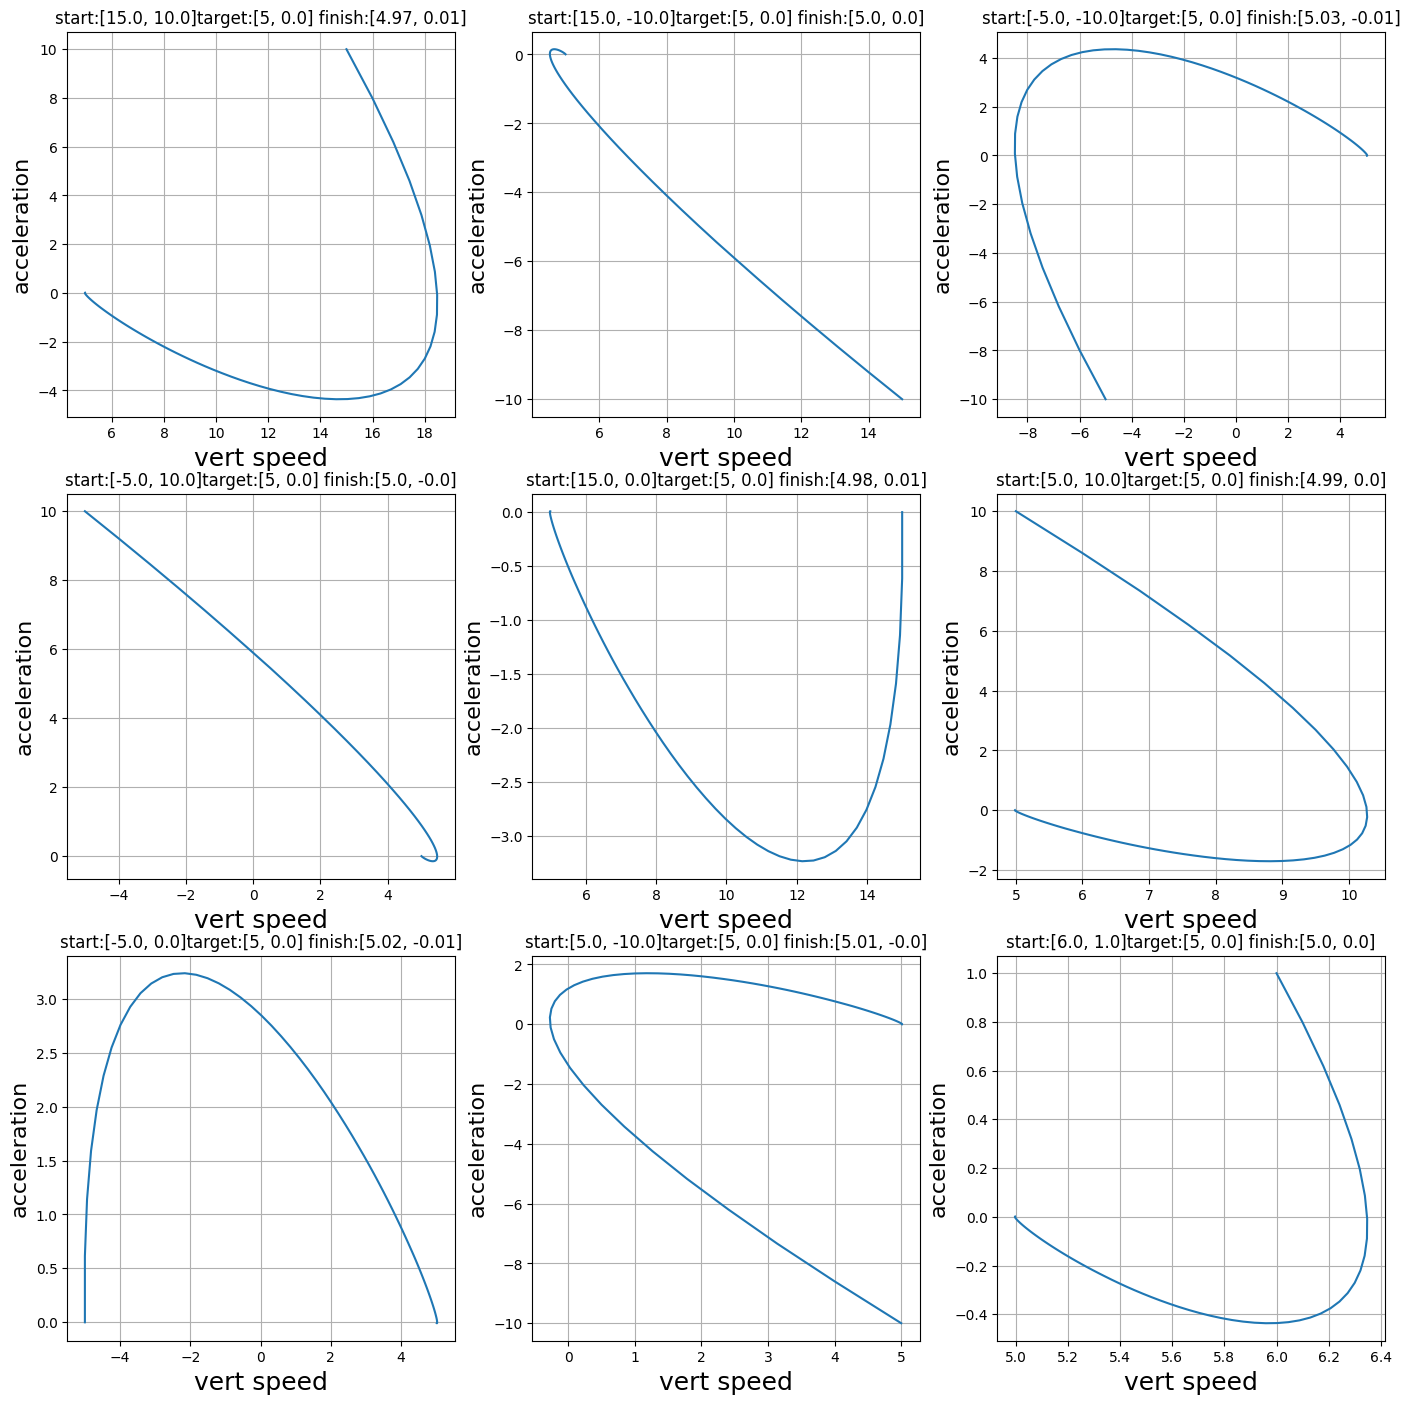

CPU times: user 48.1 s, sys: 255 ms, total: 48.3 s
Wall time: 49.4 s


In [13]:
%%time
dh = -100
roc = 10
accel = -10
x = [roc]
y = [accel]

vmax = 5
h_th = 50

elev = Elevator(droc_linprm*10, accel_linprm*10, elevator_change_linprm*10, vmax, h_th)
target_roc = elev.get_target_roc(dh)
#print('target roc', target_roc)

n = 0
#plt.figure(figsize=(30, 30))
fig, axs = plt.subplots(3, 3, figsize=(17, 17))
for roc, accel in ([10., 10.], [10., -10.], [-10.,-10.], [-10.,10.], [10., 0.], [0.,10.], [-10., 0.], [0.,-10.], [1.,1.]):
  roc = target_roc + roc
  x = [roc]
  y = [accel]
  start = str([roc, accel])

  

  
  for i in range(100): #75
    da = -elev.update(dh, roc, accel).get_cm()
    #print(da, elev.get_target_roc(dh))
    roc += accel*0.1
    accel += da 
    x.append(roc)
    y.append(accel)

  #print(x[-5::1])
  #print(y[-5::1])
  axs[n//3, n%3].plot(x, y)

  axs[n//3, n%3].grid()
  axs[n//3, n%3].set_title('start:' + start + 'target:' +  str([target_roc, 0.0]) + ' finish:' + str([round(x[-1], 2),round(y[-1], 2)]))
  #plt.plot(x, y)
  axs[n//3, n%3].set_xlabel('vert speed', fontsize=18)
  axs[n//3, n%3].set_ylabel('acceleration', fontsize=16)
  n += 1

plt.show()

In [90]:
y

[0,
 -0.0007447646327737003,
 -0.0014895292655474005,
 -0.0022349829565334856,
 -0.002981814035851809,
 -0.0037307038252522282,
 -0.0044823543913324075,
 -0.005237398046052524,
 -0.005996479199600758,
 -0.006760264399981933,
 -0.0075294019392410354,
 -0.00830448170092579,
 -0.009086119533060108,
 -0.009874902248294428,
 -0.010671363333661608,
 -0.011475972579771442,
 -0.012289258156956029,
 -0.013111634625021774,
 -0.013944002484416119,
 -0.014785889258089869,
 -0.015638028434951386,
 -0.016500560216889466,
 -0.017373770556566994,
 -0.018258040389516252,
 -0.01915346195794093,
 -0.020060242457516097,
 -0.020978313737201357,
 -0.02190698546039115,
 -0.02284624870843608,
 -0.023795581981213388,
 -0.02475418216281859,
 -0.025721930111869077,
 -0.026698688100915934,
 -0.027684328771325845,
 -0.028678666392809755,
 -0.029681512597251117,
 -0.030690548192960555,
 -0.03170565455644712,
 -0.03272670729783493,
 -0.03375366517627665,
 -0.0347864225947534,
 -0.03582487030463734,
 -0.0368691567864

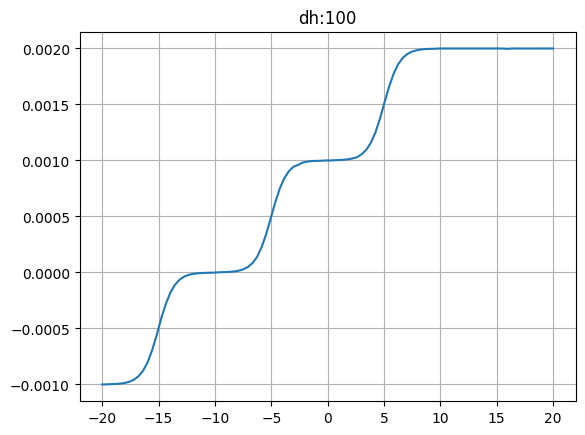

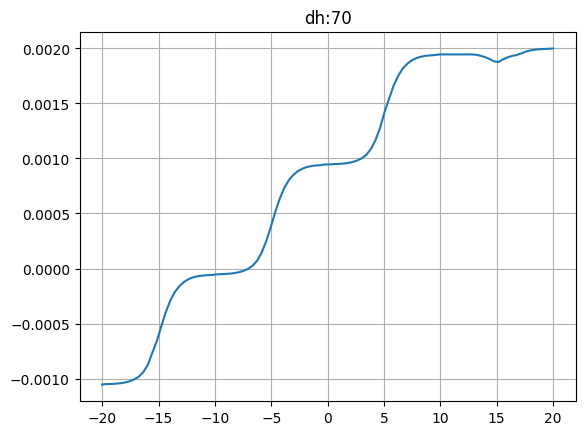

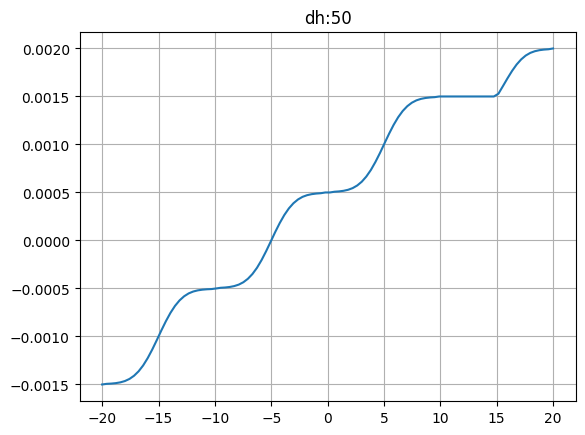

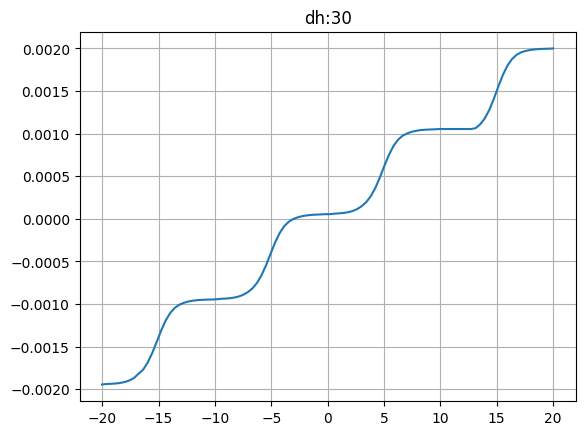

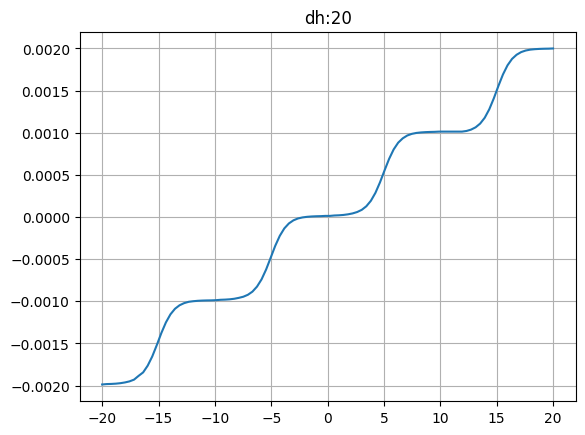

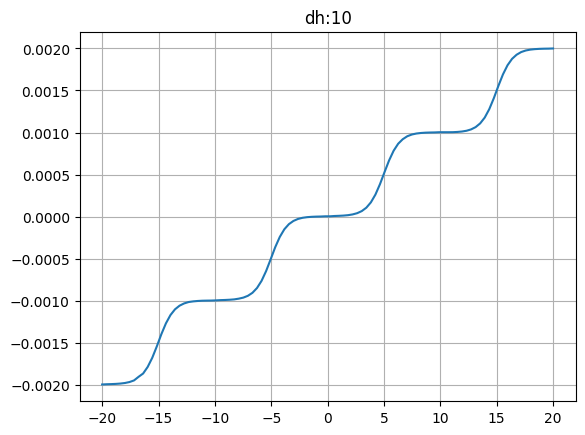

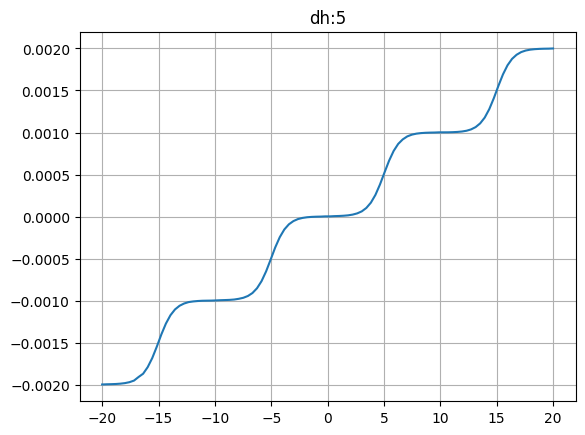

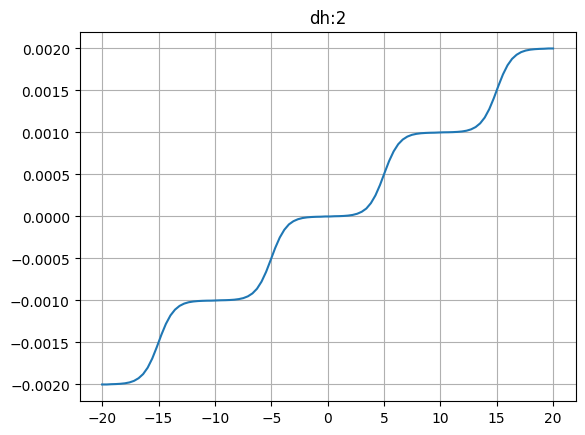

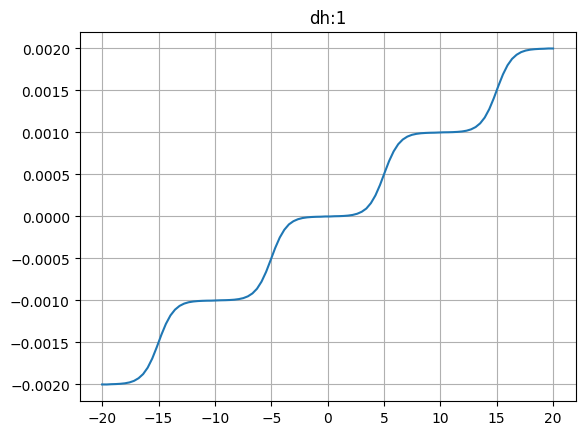

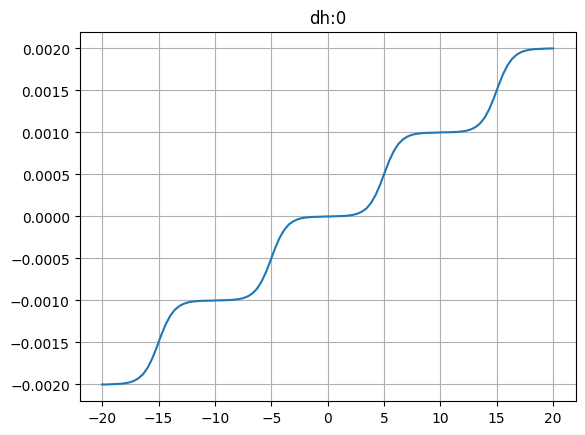

CPU times: user 11.4 s, sys: 958 ms, total: 12.4 s
Wall time: 11.5 s


In [ ]:
%%time
#kf = 2
#r = 0.5
#dhs = [0]

#kf = 5
#r = 0.5
#dhs = [100]

#kf = 3
#r = 0.5
#dhs = [50]

kf = 5
r = 0.5
sigm = 0.5
dhs = [100, 70, 50, 30, 20, 10, 5, 2, 1, 0]

elevator_change_linprm = np.array(
    [[-4*10**-4, sigm*10**-4], 
     [-r*4*10**-4, sigm*10**-4], 
     [0, sigm*10**-4],
     [r*4*10**-4, sigm*10**-4], 
     [4*10**-4, sigm*10**-4]])*kf

altitude_error_linprm = np.array(
    [[-4*10, sigm*10], 
     [-r*4*10, sigm*10], 
     [0, sigm*10],
     [r*4*10, sigm*10], 
     [4*10, sigm*10]])*kf

current_roc_linprm = np.array(
    [[-4, sigm], 
     [-r*4, sigm], 
     [0, sigm],
     [r*4, sigm], 
     [4, sigm]])*kf


x = np.linspace(-20, 20, 100)



for dh in dhs:
  y = []
  for roc in x:
    elev = Elevator(dh, roc)
    y.append(elev.get_cm())
    #print(dh, roc, round(elev.get_cm(), 6)) #,elev.defuzz_shapes, round(elev.a, 6), round(elev.b, 6))

  plt.title('dh:'+ str(dh))
  plt.grid(True)
  plt.plot(x, y)
  plt.show()

CPU times: user 303 ms, sys: 569 µs, total: 303 ms
Wall time: 308 ms


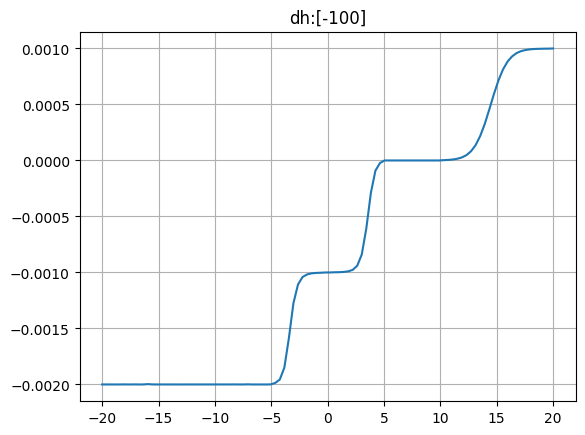

In [ ]:
%%time

elevator_change_linprm = np.array(
    [[-4*10**-4, 0.5*10**-4], 
     [-2*10**-4, 0.5*10**-4], 
     [0, 0.25*10**-4],
     [2*10**-4, 0.5*10**-4], 
     [4*10**-4, 0.5*10**-4]])*5

altitude_error_linprm = np.array(
    [[-4*10, 0.5*10], 
     [-2*10, 0.5*10], 
     [0, 0.5*10],
     [2*10, 0.5*10], 
     [4*10, 0.5*10]])*5

current_roc_linprm = np.array(
    [[-4, 0.5], 
     [-2, 0.5], 
     [0, 0.25],
     [2, 0.5], 
     [4, 0.5]])*5


x = np.linspace(-20, 20, 100)
y = []

dhs = [-100]
for dh in dhs:
  for roc in x:
    elev = Elevator(dh, roc)
    y.append(elev.get_cm())
    #print(dh, roc, round(elev.get_cm(), 6)) #,elev.defuzz_shapes, round(elev.a, 6), round(elev.b, 6))

plt.title('dh:'+ str(dhs))
plt.grid(True)
plt.plot(x, y)

CPU times: user 584 ms, sys: 1.09 ms, total: 585 ms
Wall time: 598 ms


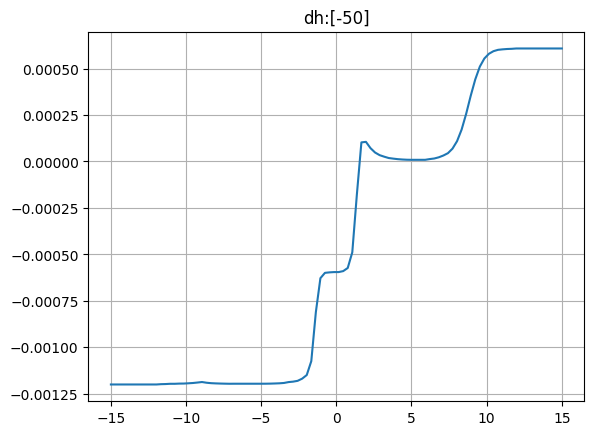

In [ ]:
%%time

elevator_change_linprm = np.array(
    [[-4*10**-4, 0.5*10**-4], 
     [-2*10**-4, 0.35*10**-4], 
     [0, 0.25*10**-4],
     [2*10**-4, 0.35*10**-4], 
     [4*10**-4, 0.5*10**-4]])*3

altitude_error_linprm = np.array(
    [[-4*10, 0.5*10], 
     [-2*10, 0.5*10], 
     [0, 0.5*10],
     [2*10, 0.5*10], 
     [4*10, 0.5*10]])*3

current_roc_linprm = np.array(
    [[-4, 0.5], 
     [-2, 0.5], 
     [0, 0.15],
     [2, 0.5], 
     [4, 0.5]])*3


x = np.linspace(-15, 15, 100)
y = []

dhs = [-50]
for dh in dhs:
  for roc in x:
    elev = Elevator(dh, roc)
    y.append(elev.get_cm())
    #print(dh, roc, round(elev.get_cm(), 6)) #,elev.defuzz_shapes, round(elev.a, 6), round(elev.b, 6))

plt.title('dh:'+ str(dhs))
plt.grid(True)
plt.plot(x, y)

CPU times: user 1.16 s, sys: 3.02 ms, total: 1.17 s
Wall time: 1.3 s


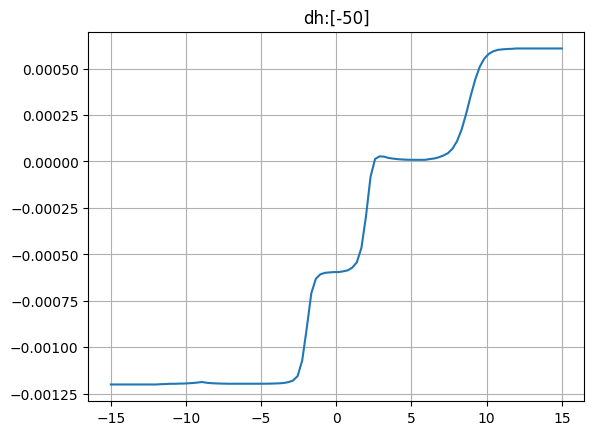

In [ ]:
%%time

elevator_change_linprm = np.array(
    [[-4*10**-4, 0.5*10**-4], 
     [-2*10**-4, 0.35*10**-4], 
     [0, 0.25*10**-4],
     [2*10**-4, 0.35*10**-4], 
     [4*10**-4, 0.5*10**-4]])*3

altitude_error_linprm = np.array(
    [[-4*10, 0.5*10], 
     [-2*10, 0.5*10], 
     [0, 0.5*10],
     [2*10, 0.5*10], 
     [4*10, 0.5*10]])*3

current_roc_linprm = np.array(
    [[-4, 0.5], 
     [-2, 0.5], 
     [0, 0.25],
     [2, 0.5], 
     [4, 0.5]])*3


x = np.linspace(-15, 15, 100)
y = []

dhs = [-50]
for dh in dhs:
  for roc in x:
    elev = Elevator(dh, roc)
    y.append(elev.get_cm())
    #print(dh, roc, round(elev.get_cm(), 6)) #,elev.defuzz_shapes, round(elev.a, 6), round(elev.b, 6))

plt.title('dh:'+ str(dhs))
plt.grid(True)
plt.plot(x, y)

CPU times: user 1 s, sys: 0 ns, total: 1 s
Wall time: 1.05 s


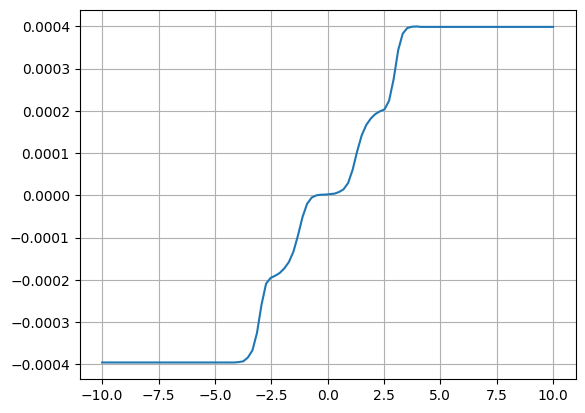

In [ ]:
%%time
x = np.linspace(-10, 10, 100)
y = []
dhs = [-40, -20, -10, -5, -3, 0, 3, 5, 10, 20, 40]
for dh in [5]:
  for roc in x:
    elev = Elevator(dh, roc)
    y.append(elev.get_cm())
    #print(dh, roc, round(elev.get_cm(), 6)) #,elev.defuzz_shapes, round(elev.a, 6), round(elev.b, 6))

plt.grid(True)
plt.plot(x, y)

CPU times: user 198 ms, sys: 0 ns, total: 198 ms
Wall time: 203 ms


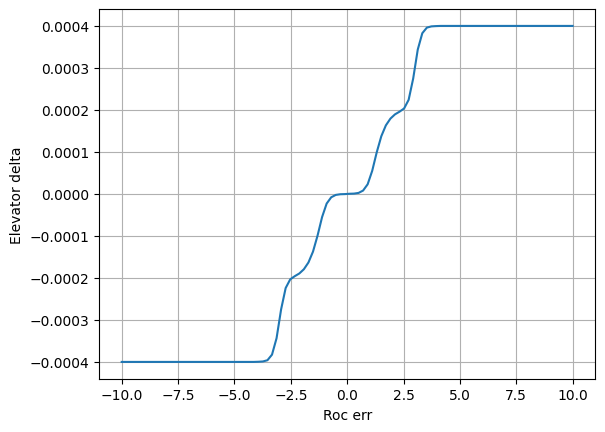

In [ ]:
%%time
x = np.linspace(-10, 10, 100)
y = []
dhs = [-40, -20, -10, -5, -3, 0, 3, 5, 10, 20, 40]
for dh in [0]:
  for roc in x:
    elev = Elevator(dh, roc)
    y.append(elev.get_cm())
    #print(dh, roc, round(elev.get_cm(), 6)) #,elev.defuzz_shapes, round(elev.a, 6), round(elev.b, 6))

plt.xlabel('Roc err')
plt.ylabel('Elevator delta')
plt.grid(True)
plt.plot(x, y)

# End

In [ ]:
def get_elevator_change(dh, roc):
  defuzz = []

  for rule in rules:

    [mn, std] = altitude_error_linprm[rule['h'] + 2]
    dh_mf = gauss_mf(dh, mn, std, edge='left' if rule['h']==-2 else 'right' if rule['h']==2 else None)

    roc_mf = 0
    for roc in rule['roc']:
      [mn, std] = current_roc_linprm[rule['roc'] + 2]
      x = gauss_mf(roc, mn, std, edge='left' if rule['h']==-2 else 'right' if rule['h']==2 else None)
      if x > roc_mf:
        roc_mf = x

    mf_value = min(dh_mf, roc_mf)
    if mf_value > 5e-4: #std < 3.9 sigma
      defuzz.append([elevator_change_linprm[rule['elevator'] + 2], mf_value])

    
  


In [ ]:
np.exp(-15/2), np.sqrt(15), 5e-4

(0.0005530843701478336, 3.872983346207417, 0.0005)

In [ ]:
for t in altitude_error_linprm:
  [mn, std] = t
  print(mn, std)

-40.0 5.0
-20.0 5.0
0.0 2.5
20.0 5.0
40.0 5.0


# Calculate the center of the mass along the x-axis efficiency

In [ ]:
%%time
avg = 5

def x_f(x):
  global h
  return  x * min(np.exp(-(x-avg) ** 2/2), h)

def f(x):
  global h
  return  min(np.exp(-(x-avg) ** 2/2), h)


r = 3
emax = 0
N = 1000
k = N//20
for i in range(N):
  h = (i+1)/N
  a = integrate.quad(x_f, avg-3., avg + r, epsrel=1e-2)
  c = integrate.quad(f, avg-3., avg + r, epsrel=1e-2)

  at = integrate.quad(x_f, avg-3., avg + r, epsrel=1e-1)
  ct = integrate.quad(f, avg-3., avg + r, epsrel=1e-1)

  if i%k==0:
    print(f"{a[0]/c[0]:.5f} {at[0]/ct[0]:.5f} \t{round(at[0]/ct[0]-a[0]/c[0], 4):{8}} \t{h:.5f}")
  
print(f"{a[0]/c[0]:.5f} {at[0]/ct[0]:.5f} \t{round(at[0]/ct[0]-a[0]/c[0], 4):{8}} \t{h:.5f}")

5.00000 5.00000 	     0.0 	0.00100
5.00000 4.99902 	  -0.001 	0.05100
5.00006 4.99919 	 -0.0009 	0.10100
5.00000 5.00011 	  0.0001 	0.15100
5.00000 5.00000 	     0.0 	0.20100
4.99998 5.00000 	     0.0 	0.25100
4.99996 5.00000 	     0.0 	0.30100
4.99960 5.00000 	  0.0004 	0.35100
4.99999 5.00000 	     0.0 	0.40100
5.00000 5.00000 	    -0.0 	0.45100
5.00000 5.00000 	     0.0 	0.50100
5.00004 5.00000 	    -0.0 	0.55100
5.00000 5.00000 	    -0.0 	0.60100
5.00000 5.00031 	  0.0003 	0.65100
5.00000 5.00005 	  0.0001 	0.70100
5.00000 5.00000 	     0.0 	0.75100
4.99989 5.00004 	  0.0002 	0.80100
5.00000 5.00000 	     0.0 	0.85100
5.00000 5.00000 	     0.0 	0.90100
5.00000 4.99997 	    -0.0 	0.95100
5.00000 5.00000 	     0.0 	1.00000
CPU times: user 1.19 s, sys: 4.72 ms, total: 1.2 s
Wall time: 1.22 s
